<a href="https://colab.research.google.com/github/junior8801/TCC_PUC_MINAS/blob/master/TCC_Ermivaldo_Cunha_de_Jesus_Junior_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h1>**PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS**</h1>
####Pós-graduação Lato Sensu em Ciência de Dados e Big Data
<br>
<h2> ANÁLISE DE MODELOS PREDITIVOS APLICADOS EM SÉRIES TEMPORAIS</h2>
<br>
<h4>Ermivaldo Cunha de Jesus Júnior</h4>


---
<br>
Este notebook é referente ao trabalho de conclusão de curso de Pós Graduação em Ciências de Dados e Big Data da turma de 2019-2021. O trabalho proposto foi a análise e exploração da base de dados de uma startup brasileira de e-commerce, realizar a análise preditiva de séries temporais do volume financeiro de pedidos na aplicação de modelos de machine learning para previsão do comportamento de demandas futuras. Fito isso, identificar o modelo que teve a melhor acurácia em suas previsões.

# **Análise**

## Importar Bibliotecas
<br>
Neste passo será realizado instalação e importação das bibliotecas necessárias para o desenvolvimento do trabalho.

In [1]:
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.2)


In [2]:
!pip install pmdarima

In [3]:
!pip install fbprophet

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline
#%config InlineBackend.figure_format='svg'

from google.colab import drive

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

from pmdarima.arima import auto_arima

from fbprophet import Prophet

import warnings 
warnings.filterwarnings('ignore')

##Carregar os dados <br>
Este trabalho é uma análise dos dados de uma startup brasileira que atua no segmento de e-commerce como um plataforma de marketplace<br>
As bases analisadas foram disponibilizadas pela própria empresa na plataforma do kaggle no endereço abaixo. </br>
https://www.kaggle.com/olistbr/brazilian-ecommerce</br>
Acesso dia 13/01/2021.<br>
Abaixo tem uma imagem com a modelagem do relacionamento entre os datasets utilizados.


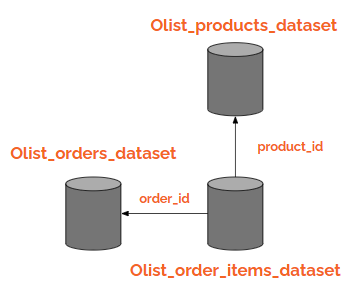

Após efetuado o download foi disponibilizado via Google Drive para o carregamento no Google Colab. 

In [5]:
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


Carregamento dos DataSets a partir das bases do google drive.

In [6]:
df_orders = pd.read_csv('/gdrive/My Drive/olist/olist_orders_dataset.csv')
df_items = pd.read_csv("/gdrive/My Drive/olist/olist_order_items_dataset.csv")
df_products = pd.read_csv("/gdrive/My Drive/olist/olist_products_dataset.csv")

##DataSets

#####**df_orders** = DataSet com as informações sobre os pedidos, tempo de entrega status e data venda. Este DataSet possui 99.441 linhas e 8 colunas/variáveis

In [7]:
print(df_orders.describe())
print('Possui {l} linhas'.format(l=df_orders.shape[0]))

                                order_id  ... order_estimated_delivery_date
count                              99441  ...                         99441
unique                             99441  ...                           459
top     baa297bb0f3189e5aec7838ec35b5efc  ...           2017-12-20 00:00:00
freq                                   1  ...                           522

[4 rows x 8 columns]
Possui 99441 linhas


In [8]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [9]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
pd.to_datetime(df_orders['order_purchase_timestamp']).dt.date.nunique()

634

São 634 dias de observação.

In [11]:
print(pd.to_datetime(df_orders['order_purchase_timestamp']).dt.date.min())
print(pd.to_datetime(df_orders['order_purchase_timestamp']).dt.date.max())

2016-09-04
2018-10-17


Estão compreendidas entre 04/09/2016 e 17/10/2018.

#####**df_items** = DataSet com os itens vendidos traz uma referência do produto, valor total do item e valor do frete para o item. Ele possui 112.650 linhas e 7 colunas, neste dataset tem duplicidade no order_id, visto que cada pedido pode tem mais de um item, o que unifica cada item é a chave composta por order_id e order_item_id. Temos 98.666 pedidos unicos.



In [12]:
df_items.order_id.nunique()

98666

In [13]:
print(df_items.describe())
print('Possui {l} linhas'.format(l=df_items.shape[0]))

       order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000
Possui 112650 linhas


In [14]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [15]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
##quantidade de itens por pedido
df_items['order_id'].value_counts()

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
                                    ..
15b5cb72b88eef3759d55a8d7cbf0a6c     1
e1509672293750128968e3d0089e1b5d     1
b56c143bc1ca0cee7345b354671f1e2d     1
4775567ae3272cb6959f86906190f1a5     1
f5147f84d290b6615104539af53179fd     1
Name: order_id, Length: 98666, dtype: int64

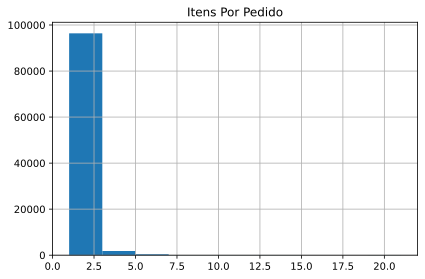

In [17]:
#distribuição da quanttidade de itens por pedido
(df_items['order_id'].value_counts()).hist()
plt.title('Itens Por Pedido')
plt.tight_layout()

#####**df_products** = DataFrame com os dados dos produtos, tem relacionamento com o dataframe df_items. Ele possui 32.951 registros

In [18]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [19]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


##Preparar Dados </br>
Nesta seção será realizado os ajustes necessários nos datasets para viabilizar a realização das análises.

###Ajustar data da venda

Como iremos trabalhar com séries temporais foi necessário no dataset de pedidos fazer a conversão do tipo de dados da coluna order_purchase_timestamp que estava com o tipo de dados “object”, para o tipo de dados “datetime”, possibilitando uma correta utilização para as análises de séries temporais, com isso foram criadas as seguintes colunas order_purchase_date e year_month, uma para armazenamento da data e outra consolidação do ano com o mês, respectivamente. 

In [20]:
##Cconverter coluna order_purchase_timestamp em datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
##Criar coluna com a data de venda
df_orders['order_purchase_date']=df_orders['order_purchase_timestamp'].dt.date
##Utilizar a coluna criada para criar a coluna year_month padrão YYYY-MM
df_orders['year_month']=df_orders['order_purchase_timestamp'].dt.strftime("%Y-%m")
df_orders['year']=df_orders['order_purchase_timestamp'].dt.year
df_orders['monthday']=df_orders['order_purchase_timestamp'].dt.day
df_orders['month']=df_orders['order_purchase_timestamp'].dt.month
df_orders['year_month_day']=df_orders['order_purchase_timestamp'].dt.strftime("%Y-%m-%d")
df_orders['year_week']=df_orders['order_purchase_timestamp'].dt.strftime('%Y-%W')

df_orders[['order_purchase_timestamp','order_purchase_date','year_month','year','monthday','month','year_month_day','year_week']].head(5)

,order_purchase_timestamp,order_purchase_date,year_month,year,monthday,month,year_month_day,year_week
0,2017-10-02 10:56:33,2017-10-02,2017-10,2017,2,10,2017-10-02,2017-40
1,2018-07-24 20:41:37,2018-07-24,2018-07,2018,24,7,2018-07-24,2018-30
2,2018-08-08 08:38:49,2018-08-08,2018-08,2018,8,8,2018-08-08,2018-32
3,2017-11-18 19:28:06,2017-11-18,2017-11,2017,18,11,2017-11-18,2017-46
4,2018-02-13 21:18:39,2018-02-13,2018-02,2018,13,2,2018-02-13,2018-07


###Consolidar valores dos itens </br>
Para facilitar a manipulação dos dados vamos consolidar a soma dos valores do items no dataset de pedidos.

In [21]:
#definir a coluna order_id do df_orders como index
df_orders.set_index('order_id', inplace = True)
##somar a coluna price do df_items
df_001 = df_items[['order_id','price']].groupby(['order_id']).sum()

##consolidar o valor dos itens na venda
df_orders =  pd.concat([df_orders, df_001], axis=1).reindex(df_orders.index)
df_orders.head(5)

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,year_month,year,monthday,month,year_month_day,year_week,price
order_id,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02,2017-10,2017,2,10,2017-10-02,2017-40,29.99
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24,2018-07,2018,24,7,2018-07-24,2018-30,118.70
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08,2018-08,2018,8,8,2018-08-08,2018-32,159.90
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18,2017-11,2017,18,11,2017-11-18,2017-46,45.00
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13,2018-02,2018,13,2,2018-02-13,2018-07,19.90


###Colocar a categoria do produto no dataset de itens do pedido </br>
Para análise exploratória vamos fazer um resumo de pedidos por categoria, essa informação temos no dataset do produto, neste caso vamos ter que alimentar o data set de items com a informação da categoria do dataset de produtos, para isso iremos utilizar a referência de product_id que temos em ambos datasets.  

In [22]:
df_items = pd.merge(df_items,df_products[['product_id','product_category_name']])

In [23]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff


In [24]:
#Validação
df_items[['product_id','product_category_name']][(df_items.product_id == "4244733e06e7ecb4970a6e2683c13e61")]


,product_id,product_category_name
0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
1,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
2,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
3,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
4,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
5,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
6,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
7,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
8,4244733e06e7ecb4970a6e2683c13e61,cool_stuff


Validação no data frame de produtos. 

In [25]:
df_products[['product_id','product_category_name']][(df_products.product_id == "4244733e06e7ecb4970a6e2683c13e61")]

,product_id,product_category_name
25865,4244733e06e7ecb4970a6e2683c13e61,cool_stuff


###Valores Faltantes </br>
Localizar dados faltantes/ausentes e efetuar os devidos tratamentos.

####Produtos

In [26]:
df_products_missing_values = df_products.isnull().sum()
for i in range(len(df_products_missing_values)):
    print("Missing rows in {} : {}".format(df_products_missing_values.index[i], df_products_missing_values.values[i]))

Missing rows in product_id : 0
Missing rows in product_category_name : 610
Missing rows in product_name_lenght : 610
Missing rows in product_description_lenght : 610
Missing rows in product_photos_qty : 610
Missing rows in product_weight_g : 2
Missing rows in product_length_cm : 2
Missing rows in product_height_cm : 2
Missing rows in product_width_cm : 2


Foi localizado 610 produtos sem a informação de categoria. Abaixo estão os produtos que estão sem a informação da categoria

In [27]:
df_products_missing_category = df_products[df_products.product_category_name.isna()]
df_products_missing_category

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


A falta destes dados poderá impactar em nossa análise de pedidos por categoria, pois utilizamos esta informação no data set de itens. Vamos fazer um levantamento para verificar o impacto da falta desta informação.


In [28]:
df_items_missing_product_category = df_items[df_items.product_id.isin(df_products_missing_category.product_id)]
print("Total de pedidos sem categoria são {} itens que somam R${} em pedidos, em todo o dataset analisado.".format(df_items_missing_product_category.price.count(), df_items_missing_product_category.price.sum()))

Total de pedidos sem categoria são 1603 itens que somam R$179535.28 em pedidos, em todo o dataset analisado.


Foram registados R$ 179.535,28 em todo o data frame de itens que se referenciam a um produto que está sem categoria. Verificar a representatividade das venda de items que estão sem categorias. 

In [29]:
df_items_missing_product_category.price.sum()/df_items.price.sum()*100

1.3209239733086882

Somente 1,32% dos pedidos não tem categoria associada. Não irá impactar em nossas análises. Dessa forma vamos preencher com o valor "outros".


In [30]:
df_products.update(df_products['product_category_name'].fillna('outros'))
## Atualizar a informação no data frame itens
df_items = df_items.drop(columns=['product_category_name'])
df_items = pd.merge(df_items,df_products[['product_id','product_category_name']])
## Validação 
df_items.query('product_category_name=="outros"').price.sum()

179535.28

####Pedidos

Validação de valores faltantes no dataframe de pedidos.

In [31]:
df_orders_missing_values = df_orders.isnull().sum()
for i in range(len(df_orders_missing_values)):
    print("Missing rows in {} : {}".format(df_orders_missing_values.index[i], df_orders_missing_values.values[i]))

Missing rows in customer_id : 0
Missing rows in order_status : 0
Missing rows in order_purchase_timestamp : 0
Missing rows in order_approved_at : 160
Missing rows in order_delivered_carrier_date : 1783
Missing rows in order_delivered_customer_date : 2965
Missing rows in order_estimated_delivery_date : 0
Missing rows in order_purchase_date : 0
Missing rows in year_month : 0
Missing rows in year : 0
Missing rows in monthday : 0
Missing rows in month : 0
Missing rows in year_month_day : 0
Missing rows in year_week : 0
Missing rows in price : 775


Temos valores faltantes de data de aprovação do pedido, data de envio para a transportadora e data de envio para o cliente, isto não impactará em nossas análises. Porém, vamos avaliar o impacto destes 775 pedidos que não estão com o valor(coluna price) preenchidos, esta coluna foi preenchida pelo df_items neste caso temos pedidos que não tem item para se referenciar. Como não teria uma forma de preencher vamos descartá-los.

Validação pedidos sem itens

In [32]:
items_order_id = df_items.order_id.unique()
df_orders_missing_items = df_orders[~df_orders.index.isin(items_order_id)]
df_orders_missing_items

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,year_month,year,monthday,month,year_month_day,year_week,price
order_id,,,,,,,,,,,,,,,
8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,2017-11-16,2017-11,2017,16,11,2017-11-16,2017-46,NaN
c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,2018-01-31,2018-01,2018,31,1,2018-01-31,2018-05,NaN
37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,2017-08-14,2017-08,2017,14,8,2017-08-14,2017-33,NaN
d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,2018-01-08,2018-01,2018,8,1,2018-01-08,2018-02,NaN
00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,2018-08-28,2018-08,2018,28,8,2018-08-28,2018-35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,2018-01-16,2018-01,2018,16,1,2018-01-16,2018-03,NaN
3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,2018-08-31,2018-08,2018,31,8,2018-08-31,2018-35,NaN
a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,2018-09-06,2018-09,2018,6,9,2018-09-06,2018-36,NaN


Vamos ver em quais estatus estão concetrados.

In [33]:
pd.value_counts(df_orders_missing_items['order_status']) 

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

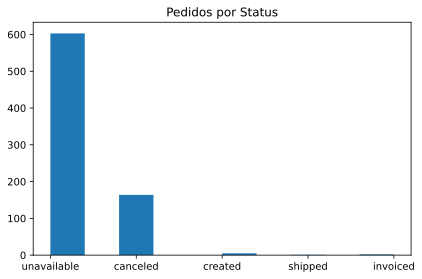

In [34]:
plt.hist(df_orders_missing_items['order_status'])
plt.title('Pedidos por Status')
plt.tight_layout()

A maioria destes pedidos estão marcados como "unavailable" e "canceled", estes status não serão contabilizados em nossas análises, podemos removê-los pois não irá nos impactar.

In [35]:
df_orders.drop(df_orders_missing_items.index, inplace=True)
df_orders.shape

(98666, 15)

####Itens

Validação do data frame de itens.

In [36]:
df_items_missing_values = df_items.isnull().sum()
for i in range(len(df_items_missing_values)):
    print("Missing rows in {} : {}".format(df_items_missing_values.index[i], df_items_missing_values.values[i]))
df_items.shape

Missing rows in order_id : 0
Missing rows in order_item_id : 0
Missing rows in product_id : 0
Missing rows in seller_id : 0
Missing rows in shipping_limit_date : 0
Missing rows in price : 0
Missing rows in freight_value : 0
Missing rows in product_category_name : 0


(112650, 8)

Não temos valores faltantes.

##Análise

<h3>Questões levantadas.</h3>

  Q1. Qual é o status com a maior quantidade de vendas e quantos pedidos temos com este status?<br>
    R1. Delivered, 96.478.

  Q2. Para quantas categorias de produtos, foi aberto pelo menos um pedido?<br>
    R2. Existem 74 categorias com pedidos realizados.

  Q3. Qual foi o melhor dia de vendas? E quanto foi vendido neste dia?<br>
    R3. O melhor dia de vendas foi dia 29/09/2017, neste dia foram realizados R$151.777,84 em pedidos.

  Q4. Qual o dia de semana com maior venda?<br>
    R4. Segunda-feira.

  Q5. Qual foi o melhor mês de vendas? Quanto foi vendido neste mês?<br>
    R5. O melhor mês de vendas foi novembro/2017, foi vendido R$999.310,64 neste mês.

###Exploração

####Visão por Status

In [37]:
orders_status = pd.value_counts(df_orders['order_status']) 
orders_status

delivered      96478
shipped         1106
canceled         461
invoiced         312
processing       301
unavailable        6
approved           2
Name: order_status, dtype: int64

**R1. Delivered, 96.478.**

Representação gáfica dos pedidos por status.

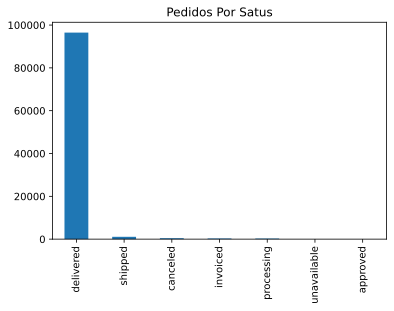

In [38]:
plt.title('Pedidos Por Satus')
orders_status.plot.bar(y="Status")
plt.show()

Podemos observar que a maior parte dos pedidos está consentrada no status "delivered", ou seja "entregue", vamos dar um zoom nos demais status.

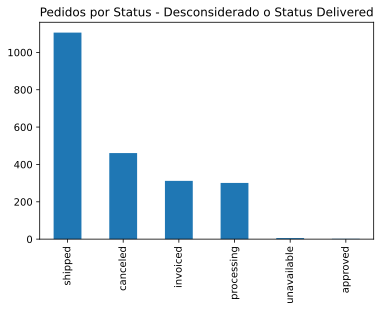

In [39]:
orders_status = orders_status[1:]
orders_status.plot.bar(y="Status")
plt.title("Pedidos por Status - Desconsiderado o Status Delivered")
plt.show()

Vamos considerar como pedidos concluídos os quais estiverem com os status delivered, shipped, invoiced, approved em nossas análises.


In [40]:
df_orders_filtred = df_orders[(df_orders.order_status == "delivered")|(df_orders.order_status == "shipped")|(df_orders.order_status == "invoiced")|(df_orders.order_status == "approved") ]
df_items_filtred = df_items[df_items.order_id.isin(df_orders_filtred.index)]

In [41]:
len(df_items_filtred)

111744

In [42]:
len(df_orders_filtred)

97898

Por tanto agora temos 97.898 pedidos e 111.744 items destes pedidos.

####Visão por categoria

In [43]:
products_cartegory = df_products.groupby(['product_category_name']).count()
products_cartegory['product_id'].sort_values(ascending=False)

product_category_name
cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
casa_conforto_2                     5
fashion_roupa_infanto_juvenil       5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_id, Length: 74, dtype: int64

Temos 74 categorias

In [44]:
orders_products_category = pd.value_counts(df_items_filtred['product_category_name']) 
orders_products_category = orders_products_category.sort_values(ascending=False)
print("Temos {} itens em {} categorias diferentes.".format(df_items_filtred.shape[0], orders_products_category.shape[0]))
orders_products_category.head()

Temos 111744 itens em 74 categorias diferentes.


cama_mesa_banho           11089
beleza_saude               9619
esporte_lazer              8566
moveis_decoracao           8259
informatica_acessorios     7764
Name: product_category_name, dtype: int64

**R2. Existem 74 categorias com pedidos realizados.**

Algumas statísticas das categorias dos produtos.

In [45]:
orders_products_category.describe()

count       74.000000
mean      1510.054054
std       2547.542183
min          2.000000
25%         77.000000
50%        276.500000
75%       1657.750000
max      11089.000000
Name: product_category_name, dtype: float64

In [46]:
orders_products_category.tail()

la_cuisine                       14
cds_dvds_musicais                14
pc_gamer                          8
fashion_roupa_infanto_juvenil     7
seguros_e_servicos                2
Name: product_category_name, dtype: int64

Primeiras vamos exibir as 30 categorias com a somatória dos valores dos itens (em R$) ordenadas da categoria com o maior valor para a categoria com o menor valor.

Criando um dataframe para o agrupamento dos pedidos por categoria.


In [47]:
orders_products_category = df_items.groupby(['product_category_name']).sum()
orders_products_category.sort_values(by=['price'],ascending=False, inplace=True)
orders_products_category.head(30)

,order_item_id,price,freight_value
product_category_name,,,
beleza_saude,11081,1258681.34,182566.73
relogios_presentes,6594,1205005.68,100535.93
cama_mesa_banho,13665,1036988.68,204693.04
esporte_lazer,9932,988048.97,168607.51
informatica_acessorios,9874,911954.32,147318.08
moveis_decoracao,11540,729762.49,172749.30
cool_stuff,4077,635290.85,84039.10
utilidades_domesticas,9051,632248.66,146149.11
automotivo,4881,592720.11,92664.21


Representação gráfica dos pedidos por categoria.


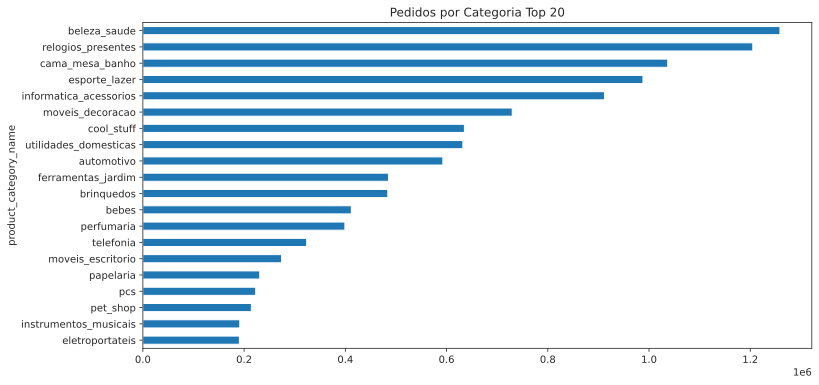

In [48]:
sns.set_style("ticks")
plt.figure( figsize=(12, 6) )
orders_products_category.price[:20].plot.barh(y="Categoria")
plt.title("Pedidos por Categoria Top 20")
plt.gca().invert_yaxis()
plt.show()

####Visão de pedidos por dia

Abertura diária

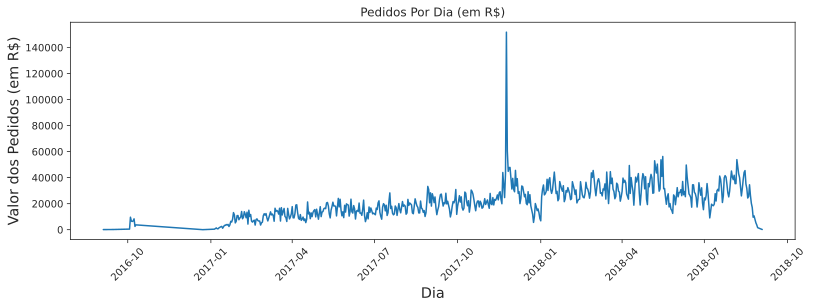

In [49]:
df_orders_filtred_day = df_orders_filtred[['order_purchase_date','price']].groupby('order_purchase_date').sum()
df_orders_filtred_day.reset_index(inplace=True)
df_orders_filtred_day['order_purchase_date'] = pd.to_datetime(df_orders_filtred_day['order_purchase_date'])
df_orders_filtred_day.set_index('order_purchase_date', inplace=True)
df_orders_filtred_day.sort_index(inplace=True)

plt.figure(figsize=(13,4))
plt.xticks(rotation=45)
plt.title('Pedidos Por Dia (em R$)')
ax = sns.lineplot(x=df_orders_filtred_day.index,y='price',data=df_orders_filtred_day)
ax.set_xlabel('Dia',size='x-large')
ax.set_ylabel('Valor dos Pedidos (em R$)', size='x-large')
plt.show()

In [50]:
df_orders_filtred_day.describe()

,price
count,614.000000
mean,21879.416156
std,12517.411827
min,10.900000
25%,12907.047500
50%,20337.355000
75%,29308.427500
max,151777.840000


In [51]:
df_orders_filtred_day.tail(10)

,price
order_purchase_date,
2018-08-21,26323.06
2018-08-22,20297.13
2018-08-23,17030.87
2018-08-24,9585.71
2018-08-25,10599.41
2018-08-26,8070.71
2018-08-27,5345.91
2018-08-28,3673.91
2018-08-29,1546.04


vamos expurgar da base estes três últimos períodos, pois estão muito discrepantes.

In [52]:
df_orders_filtred_day

,price
order_purchase_date,
2016-09-04,72.89
2016-09-15,134.97
2016-10-03,441.98
2016-10-04,9571.16
2016-10-05,6589.56
...,...
2018-08-26,8070.71
2018-08-27,5345.91
2018-08-28,3673.91


In [53]:
df_orders_filtred_day.head(20)

,price
order_purchase_date,
2016-09-04,72.89
2016-09-15,134.97
2016-10-03,441.98
2016-10-04,9571.16
2016-10-05,6589.56
2016-10-06,6295.72
2016-10-07,6728.25
2016-10-08,8306.86
2016-10-09,2519.20


podemos ver também que estas 11 primeiras observações estão muito discrepantes vamos expurgá-las

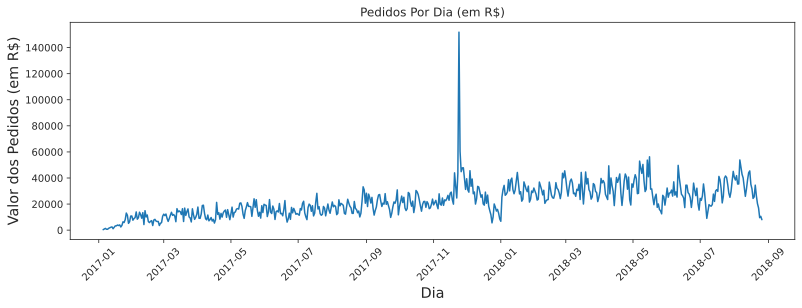

In [54]:
##remover dias outliers
df_orders_filtred.reset_index(inplace=True)
df_orders_filtred.set_index('order_purchase_timestamp',inplace=True)

df_orders_filtred = df_orders_filtred[df_orders_filtred.index >= '2016-12-31']
df_orders_filtred = df_orders_filtred[df_orders_filtred.index <= '2018-08-27']
df_orders_filtred_day = df_orders_filtred[['order_purchase_date','price']].groupby('order_purchase_date').sum()
df_orders_filtred_day.reset_index(inplace=True)
df_orders_filtred_day['order_purchase_date']=pd.to_datetime(df_orders_filtred_day['order_purchase_date'])
df_orders_filtred_day.set_index('order_purchase_date',inplace=True)

plt.figure(figsize=(13,4))
plt.xticks(rotation=45)
plt.title('Pedidos Por Dia (em R$)')
ax = sns.lineplot(x=df_orders_filtred_day.index,y='price',data=df_orders_filtred_day)
ax.set_xlabel('Dia',size='x-large')
ax.set_ylabel('Valor dos Pedidos (em R$)', size='x-large')
plt.show()

Decomposição dos padrões. 
Vamos utilizar a bibilioteca statsmodel para fazer a decomposição dos padrões de nossos dados.

In [55]:
df_orders_filtred_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 599 entries, 2017-01-05 to 2018-08-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   599 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


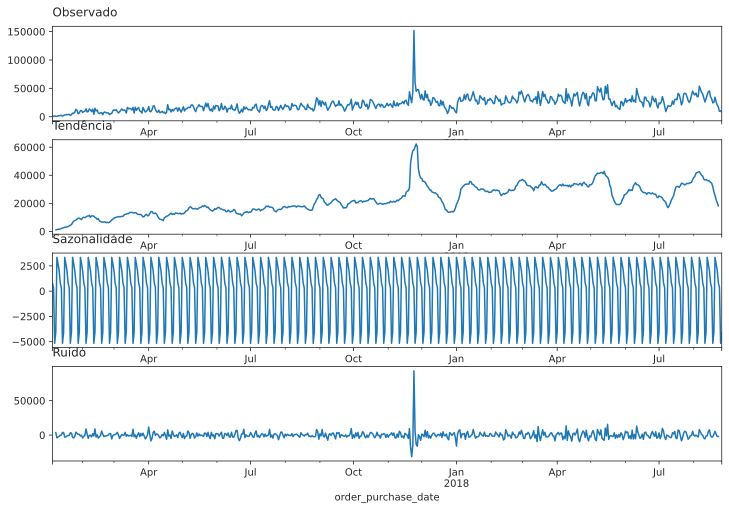

In [56]:
result_day_decompose = seasonal_decompose(df_orders_filtred_day,period=7)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8)) 
result_day_decompose.observed.plot(ax=ax1)
ax1.set_title('Observado',loc='left',fontsize=12,pad=10) 
result_day_decompose.trend.plot(ax=ax2) 
ax2.set_title('Tendência',loc='left',fontsize=12,pad=10) 
result_day_decompose.seasonal.plot(ax=ax3) 
ax3.set_title('Sazonalidade',loc='left',fontsize=12,pad=10) 
result_day_decompose.resid.plot(ax=ax4) 
ax4.set_title('Ruído',loc='left',fontsize=12,pad=10) 
plt.show()

Podemos observar que temos uma tendência de crescimento de vendas até abril de 2018 e depois começa uma tendência de baixa e também nos mostra que nossa série apresenta componente sazonal.

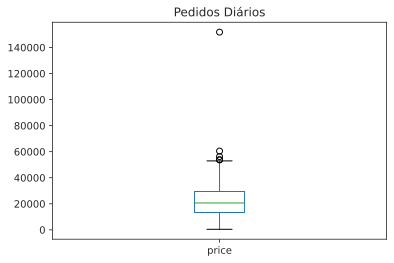

In [57]:
df_orders_filtred_day.price.plot(kind='box')
plt.title("Pedidos Diários")
plt.show()

Verificar o dia com maior número de vendas.

In [58]:
df_orders_filtred_day.sort_values(by='price',ascending=False).head(1)

,price
order_purchase_date,
2017-11-24,151777.84


**R3. O melhor dia de vendas foi dia 29/09/2017, neste dia foram realizados R$151.777,84 em pedidos.**

Vamos verificar que dia de semana foi este.

In [59]:
df_orders_filtred_day.sort_values(by='price',ascending=False).head(1).index.day_name()[0]

'Friday'

In [60]:
df_orders_filtred_day.sort_values(by='price',ascending=False).head(1).index.month_name()[0]

'November'

O dia com maior número de vendas foi dia 2017-11-24, última sexta-feira de novembro, black friday.

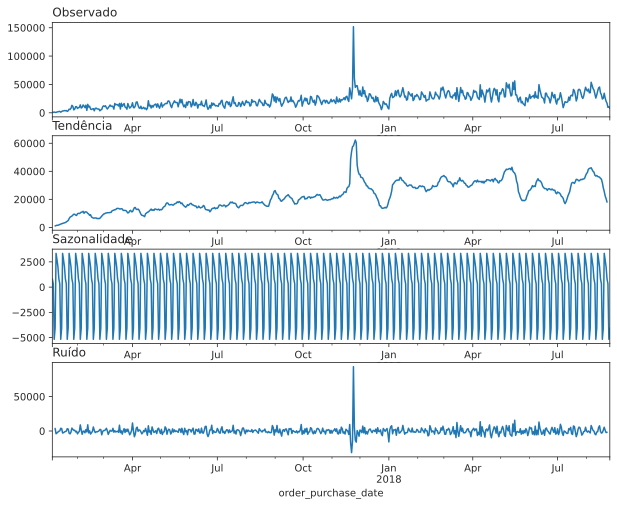

In [61]:
result_day_decompose = seasonal_decompose(df_orders_filtred_day)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(10,8)) 
result_day_decompose.observed.plot(ax=ax1)
ax1.set_title('Observado',loc='left') 
result_day_decompose.trend.plot(ax=ax2) 
ax2.set_title('Tendência',loc='left') 
result_day_decompose.seasonal.plot(ax=ax3) 
ax3.set_title('Sazonalidade',loc='left') 
result_day_decompose.resid.plot(ax=ax4) 
ax4.set_title('Ruído',loc='left') 
plt.show()

Vendas por dia de semana.

Ranking de vendas por dia de semana ordenado pela somatória dos valores de pedidos, do maior para o menor.

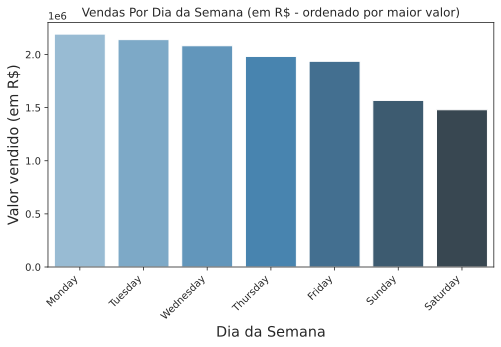

In [62]:
df_orders_filtred_week_weekday = df_orders_filtred_day.copy()

df_orders_filtred_week_weekday['day_name'] = df_orders_filtred_week_weekday.index.day_name()
df_orders_filtred_week_weekday_sum = df_orders_filtred_week_weekday[['day_name','price']].groupby('day_name').sum()
df_orders_filtred_week_weekday_sum.sort_values('price', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
fig.autofmt_xdate(rotation=45)
plt.title('Vendas Por Dia da Semana (em R$ - ordenado por maior valor)')
ax = sns.barplot(x=df_orders_filtred_week_weekday_sum.index,y='price',data=df_orders_filtred_week_weekday_sum,palette="Blues_d")
ax.set_xlabel('Dia da Semana',size='x-large')
ax.set_ylabel('Valor vendido (em R$)', size='x-large')
plt.show()

In [63]:
df_orders_filtred_week_weekday_sum

,price
day_name,
Monday,2191671.36
Tuesday,2140116.70
Wednesday,2082014.79
Thursday,1981492.38
Friday,1935919.57
Sunday,1567841.50
Saturday,1479830.30


Média de vendas por dia de semana

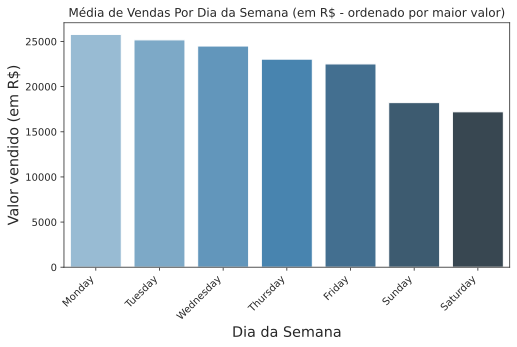

In [64]:
df_orders_filtred_week_weekday_mean = df_orders_filtred_week_weekday[['day_name','price']].groupby('day_name').mean()
df_orders_filtred_week_weekday_mean.sort_values('price', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(8,5))
fig.autofmt_xdate(rotation=45)
plt.title('Média de Vendas Por Dia da Semana (em R$ - ordenado por maior valor)')
ax = sns.barplot(x=df_orders_filtred_week_weekday_mean.index,y='price',data=df_orders_filtred_week_weekday_mean,palette="Blues_d")
ax.set_xlabel('Dia da Semana',size='x-large')
ax.set_ylabel('Valor vendido (em R$)', size='x-large')
plt.show()

In [65]:
df_orders_filtred_week_weekday_mean

,price
day_name,
Monday,25784.368941
Tuesday,25177.843529
Wednesday,24494.291647
Thursday,23040.609070
Friday,22510.692674
Sunday,18230.715116
Saturday,17207.329070


**R4. Segunda-feira.**



Venda por hora

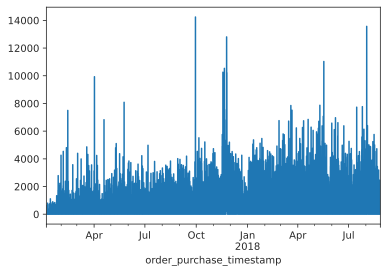

In [66]:
df_orders_filtred_h = df_orders_filtred.copy()
df_orders_filtred_h.reset_index(inplace=True)
df_orders_filtred_h.set_index('order_purchase_timestamp', inplace=True)
df_orders_filtred_h = df_orders_filtred_h['price'].resample('H').sum()
df_orders_filtred_h.plot()

####Visão de pedidos por semana

Abertura semanal

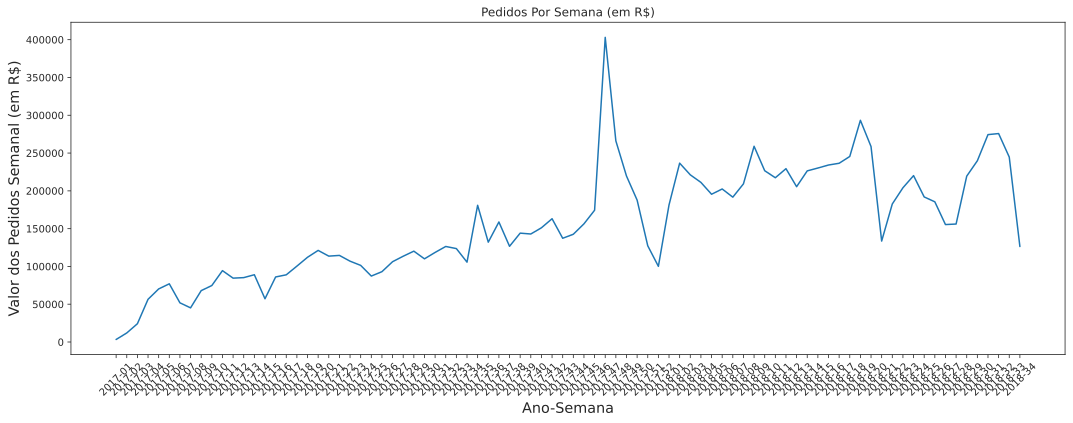

In [67]:
df_orders_filtred_week = df_orders_filtred[['year_week','price']].groupby('year_week').sum()

plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
plt.title('Pedidos Por Semana (em R$)')
ax = sns.lineplot(x=df_orders_filtred_week.index,y='price',data=df_orders_filtred_week)
ax.set_xlabel('Ano-Semana',size='x-large')
ax.set_ylabel('Valor dos Pedidos Semanal (em R$)', size='x-large')
plt.tight_layout()

Veja que fica mais difícil indetificarmos a tendência. Vamos fazer uma média móvel simples de 4 períodos semanais, o que por sua vez seria equivalente a um mês.

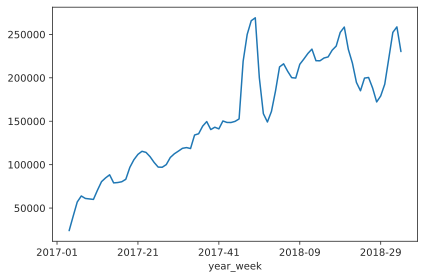

In [68]:
df_orders_filtred_week.price.rolling(4).mean().plot()
plt.tight_layout()

Agora já conseguimos notar uma certa semelhança com o gráfico de vendas mensal e ficou mais evidente a tendência de crescimento.

Decomposição dos padrões que compões os dados observados

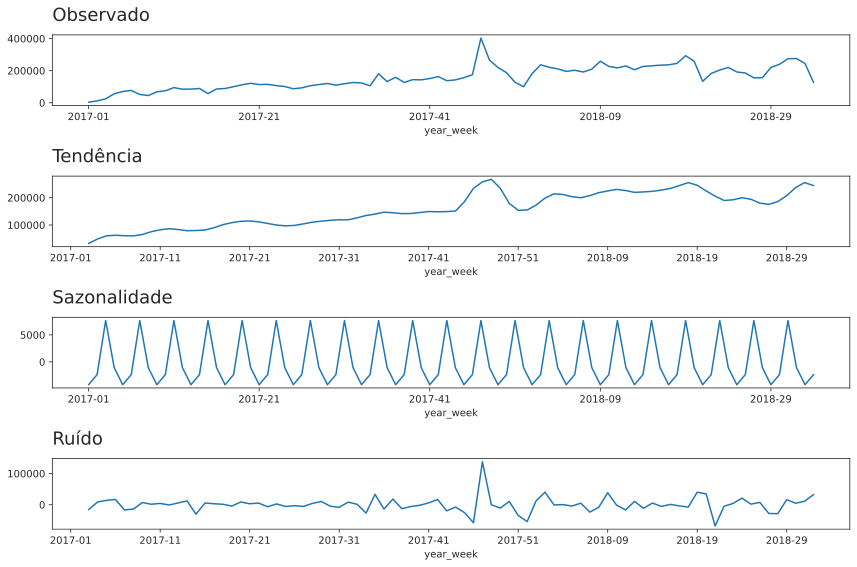

In [69]:
result_week_decompose = seasonal_decompose(df_orders_filtred_week,period=4)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8)) 
result_week_decompose.observed.plot(ax=ax1)
ax1.set_title('Observado',loc='left',fontsize=18,pad=14) 
result_week_decompose.trend.plot(ax=ax2) 
ax2.set_title('Tendência',loc='left',fontsize=18,pad=14) 
result_week_decompose.seasonal.plot(ax=ax3) 
ax3.set_title('Sazonalidade',loc='left',fontsize=18,pad=14) 
result_week_decompose.resid.plot(ax=ax4) 
ax4.set_title('Ruído',loc='left',fontsize=18,pad=14) 
plt.tight_layout()

Confirmando podemos observar os componentes de tendência e sazonalidade.

####Visão pedidos por mês

Valor médio de vendas diária dentro do mês.

In [70]:
df_month_mean = df_orders_filtred_day['price'].resample('MS').mean()
df_month_count = df_orders_filtred_day['price'].resample('MS').count()
df_month_sum = df_orders_filtred_day['price'].resample('MS').sum()
df_month = pd.concat([df_month_mean, df_month_count, df_month_sum], axis=1).reindex(df_month_mean.index)
df_month.columns = ['mean','count','sum']
df_month

,mean,count,sum
order_purchase_date,,,
2017-01-01,4362.285556,27,117781.71
2017-02-01,8539.249643,28,239098.99
2017-03-01,11729.092581,31,363601.87
2017-04-01,11601.661000,30,348049.83
2017-05-01,16110.232903,31,499417.22
2017-06-01,14253.363000,30,427600.89
2017-07-01,15832.303871,31,490801.42
2017-08-01,18190.706774,31,563911.91
2017-09-01,20586.463667,30,617593.91


Abertura mensal

<Figure size 936x288 with 0 Axes>

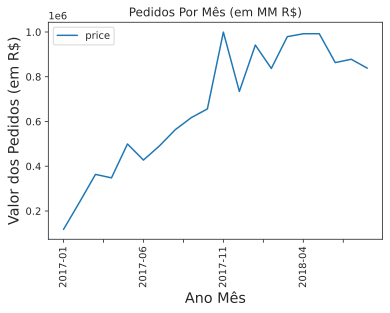

In [71]:
df_orders_filtred_month = df_orders_filtred[['year_month','price']].groupby('year_month').sum()
plt.figure(figsize=(13,4))
df_orders_filtred_month.plot()
plt.xticks(rotation=90)
plt.title('Pedidos Por Mês (em MM R$)')
plt.xlabel('Ano Mês',size='x-large')
plt.ylabel('Valor dos Pedidos (em R$)', size='x-large')
plt.show()

Variação dos pedidos</br>
Isolando a componente de variação. Equação (Pedidos do mês - Pedidos do mês anterior).

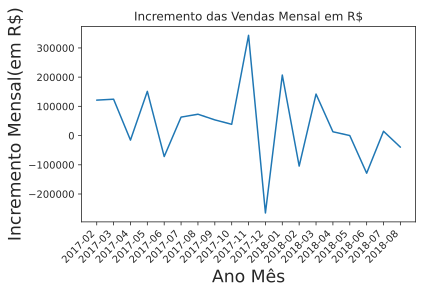

In [72]:
df_orders_filtred_month['m_1'] = df_orders_filtred_month.price.shift(1)
df_orders_filtred_month['increase'] = df_orders_filtred_month['price'] - df_orders_filtred_month['m_1']

fig, ax = plt.subplots()
fig.autofmt_xdate(rotation=45)
plt.title('Incremento das Vendas Mensal em R$')
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x='year_month',y='increase',data=df_orders_filtred_month,palette="Dark2")
ax.set_xlabel('Ano Mês',size='x-large')
ax.set_ylabel('Incremento Mensal(em R$)', size='x-large')
plt.show()

Aceleração</br>
Isolando a componente de aceleração, a velocidade da variação dos pedidos. Equação (Incremento do mês atual - Incremento do mês anterior) onde o incremento do mês atual é (Pedidos do mês atual - Pedidos do mês anterior) e o incremento do mes anterior é (Pedidos do mês anterior - Pedidos de dois meses atrás). Exemplo para a aceleração do mês de março:
((Pedidos de março - Pedidos de fevereiro)-(Pedidos de fevereiro - Pedidos de Janeiro))


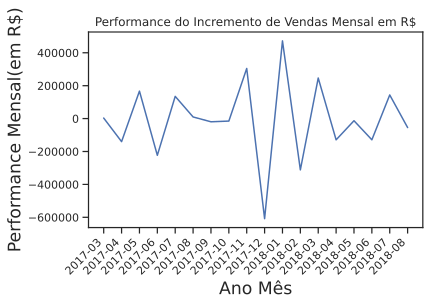

In [73]:
sns.set_style("ticks")
df_orders_filtred_month['acceleration'] = df_orders_filtred_month['increase']-df_orders_filtred_month.increase.shift(1)
fig, ax = plt.subplots()
fig.autofmt_xdate(rotation=45)
plt.title('Performance do Incremento de Vendas Mensal em R$')
ax = sns.lineplot(x='year_month',y='acceleration',data=df_orders_filtred_month)
ax.set_xlabel('Ano Mês',size='x-large')
ax.set_ylabel('Performance Mensal(em R$)', size='x-large')
plt.show()



Podemos observar que tivemos uma redução no volume finaceiro de pedidos muito grande em dezembro de 2017, logo após um mês com excelente crescimento em novembro de 2017, enquando tivemos um crescimento expressivo em janeiro de 2018.  

Melhor mês de vendas

In [74]:
df_orders_filtred_month_001 = df_orders_filtred_month.sort_values(by ='year_month' , ascending=True)
df_orders_filtred_month_001.sort_values(by ='price' , ascending=False, inplace=True)
df_orders_filtred_month_001.head(1).index[0]

'2017-11'

In [75]:
df_orders_filtred_month_001.query('year_month == "2017-11" or year_month == "2017-12" or year_month == "2017-10"' ).sort_index()

,price,m_1,increase,acceleration
year_month,,,,
2017-10,656134.23,617593.91,38540.32,-15141.68
2017-11,999310.64,656134.23,343176.41,304636.09
2017-12,734276.94,999310.64,-265033.70,-608210.11


In [76]:
#Quais os maiores dias de vendas em novembro
df_orders_filtred_day_november = pd.DataFrame( df_orders.query('year_month == "2017-11"' ))
df_orders_filtred_day_november = df_orders_filtred_day_november.groupby(['order_purchase_date']).sum()
df_orders_filtred_day_november.sort_values('price',ascending=False)
df_orders_filtred_day_november = df_orders_filtred_day_november['price']
df_orders_filtred_day_november.head()

order_purchase_date
2017-11-01    19383.61
2017-11-02    21263.73
2017-11-03    22844.05
2017-11-04    19169.07
2017-11-05    17327.44
Name: price, dtype: float64

Visão gráfica mensal

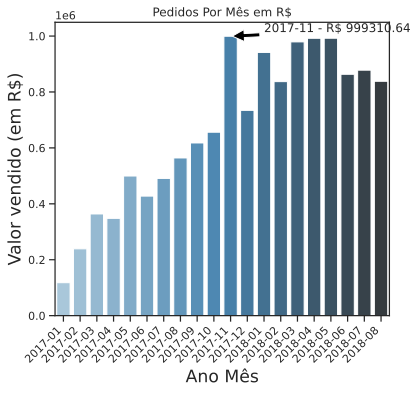

In [77]:
df_orders_filtred_month_002 = df_orders_filtred_month_001.copy()
maiorvalor = np.abs(df_orders_filtred_month_002["price"].values).max()
mes = df_orders_filtred_month_002.head(1).index[0]
descricao = '{mes} - R$ {valor}'

descricao = descricao.format(mes = str(mes), valor =  maiorvalor.round(2))

df_orders_filtred_month_002.sort_index(inplace=True)
df_orders_filtred_month_002.reset_index(inplace=True)
position = df_orders_filtred_month_002[df_orders_filtred_month_002.year_month=='2017-11'].index.values
df_orders_filtred_month_002.set_index('year_month',inplace=True)

fig, ax = plt.subplots(figsize=(6,6))
fig.autofmt_xdate(rotation=45)
plt.title('Pedidos Por Mês em R$')
ax = sns.barplot(x=df_orders_filtred_month_002.index,y='price',data=df_orders_filtred_month_002,palette="Blues_d")
ax.set_xlabel('Ano Mês',size='x-large')
ax.set_ylabel('Valor vendido (em R$)', size='x-large')
ax.annotate(descricao, xy=(position, maiorvalor), xytext=(position+2, maiorvalor+15000),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

**R4. O melhor mês de vendas foi novembro/2017, foi vendido R$999.310,64 neste mês.**

#**Aplicação dos Modelos Preditivos**

####A série temporal observada

Iremos utilizar em nossas análises as observações com abertura diária. Abaixo uma representação gráfica da série utilizada.

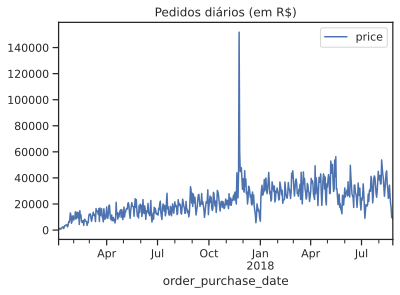

In [78]:
sns.set_style("ticks")
df_orders_filtred_day.plot()
plt.title('Pedidos diários (em R$)')
plt.show()

####Decomposição da Série

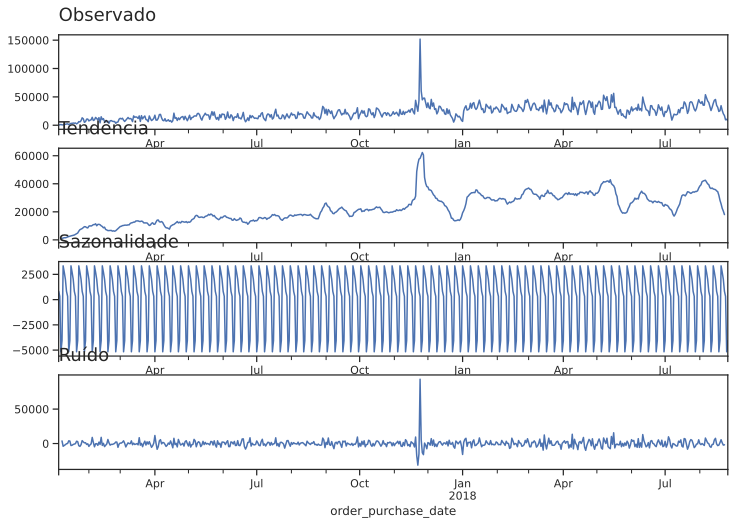

In [79]:
result_day_decompose = seasonal_decompose(df_orders_filtred_day,period=7)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8)) 
result_day_decompose.observed.plot(ax=ax1)
ax1.set_title('Observado',loc='left',fontsize=18,pad=14) 
result_day_decompose.trend.plot(ax=ax2) 
ax2.set_title('Tendência',loc='left',fontsize=18,pad=14) 
result_day_decompose.seasonal.plot(ax=ax3) 
ax3.set_title('Sazonalidade',loc='left',fontsize=18,pad=14) 
result_day_decompose.resid.plot(ax=ax4) 
ax4.set_title('Ruído',loc='left',fontsize=18,pad=14) 
plt.show()

Podemos notar que temos uma sazonalidade forte e uma tendência de alta.

####Medidas de Qualidade das Previsões

Primeiramente vamos definir as métricas de validação da qualidade de nossos modelos de previsões. 
Usaremos as métricas MAE, MAPE, MSE e RMSE.

MAE = Mean Absolute Error, média dos valores absolutos de erros, os erros são obtidos a partir da subtração da previsão pelos dados reais, é de fácil interpretação pois vai estar na mesma unidade de medida dos dados.<br>
MAPE = Mean Absolute Percentage Error, média do percentual dos erros em valores absolutos, soma-se todos os percentuais de erro, em valores absolutos, e divide-se pela quantidade de registros. Seu valor é determinado em percentual.<br>
MSE = Mean Squared Error, média quadrática do erro, neste método se eleva ao quadrado cada erro e calcula-se a média, penalizando assim o modelo que tiver o erro mais distante da média, ou seja, o que tem uma dispersão maior.<br>
RMSE = Root Mean Squared Error, raiz da média quadrática do erro, é basicamente o desvio padrão dos erros, sendo a raiz quadrada da potência dos erros dividido pela quantidade de registros.<br>

In [80]:
df_results = pd.DataFrame(columns=['Model', 'MAE', 'MAPE', 'MSE','RMSE'])
df_resids = pd.DataFrame()

In [81]:
def mean_absolute_percentage_error (y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

def prediction_teste_error (model, y_true, y_pred):
  MAE = mean_absolute_error(y_true=y_true, y_pred=y_pred)
  MAPE = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
  MSE = mean_squared_error(y_true=y_true, y_pred=y_pred)
  RMSE = np.sqrt(MSE)  
  global df_results,df_resids
  df_results = df_results[(df_results.Model != model)]
  df_results.loc[df_results.size+1] = [model,MAE,MAPE,MSE,RMSE]  
  #df_resids = df_resids[(df_resids.Model != model)]
  df_resids[model] = y_true-y_pred  
  print("Modelo {} Resultados: MAE : {}, MAPE : {}, MSE : {}, RMSE : {} ".format(model, MAE, MAPE, MSE, RMSE))  

####Autocorrelação e Autocorrelação Parcial</BR>
Vamos verificar a auto correlação.

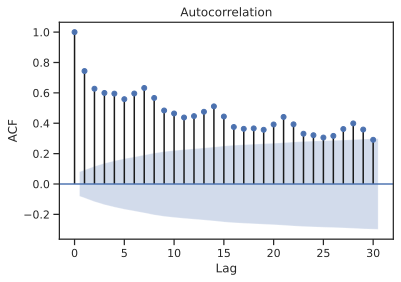

In [82]:
df_orders_filtred_day_pred = df_orders_filtred_day.copy()
plot_acf(df_orders_filtred_day_pred.price,lags=30)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()


Podemos observar que os dados são bem auto correlacionados, dessa forma vamos considerar o lag=1 para nossos modelos.

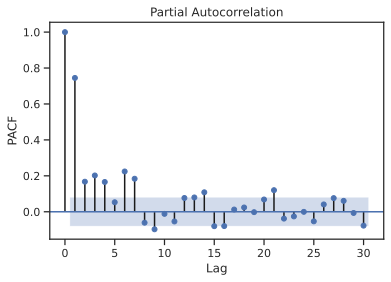

In [83]:
df_orders_filtred_day_pred = df_orders_filtred_day.copy()
plot_pacf(df_orders_filtred_day_pred.price,lags=30)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


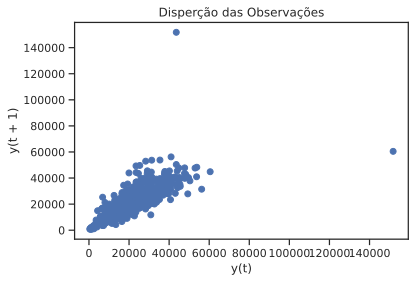

In [84]:
pd.plotting.lag_plot(df_orders_filtred_day_pred)
plt.title("Disperção das Observações")
plt.show()

Podemos obsservar que temos uma variável com um padrão linear muito bem correlacionado, o modelo autoregressivo seria o mais indicado.

####Separação de base entre Treino e Teste

In [85]:
df_orders_filtred_day_pred.count()

price    599
dtype: int64

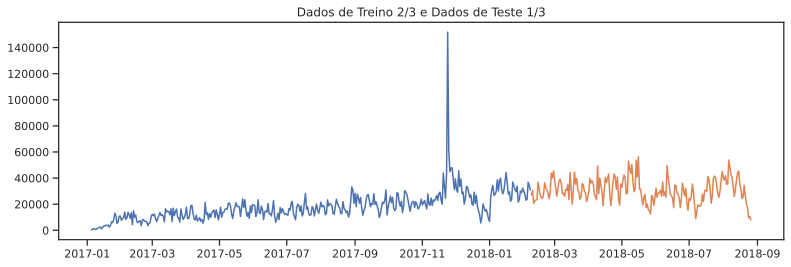

In [86]:
train_size = int(len(df_orders_filtred_day_pred) * 2/3)
ds_day_train = df_orders_filtred_day_pred.price[:train_size]
ds_day_test = df_orders_filtred_day_pred.price[train_size:]

plt.figure(figsize=(13,4))
plt.plot(ds_day_train)
plt.plot(ds_day_test)
plt.title("Dados de Treino 2/3 e Dados de Teste 1/3")
plt.show()

In [87]:
#para preencher a tabela de erros com todas as datas
df_resids['y'] = ds_day_test

In [88]:
df_orders_filtred_day_pred.count()

price    599
dtype: int64

In [89]:
#Treino
ds_day_train.count()

399

In [90]:
#Teste
ds_day_test.count()

200

####Estacionariedade

Para verificar a estacionariedade vamos utilizar o teste de Dickey Fuller.

In [91]:
def adf_test(y):
    print('Resultado do Teste Dickey-Fuller:')
    dftest = adfuller(y, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Teste','Valor p', 'Nº de lags', 'Nº de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico ({})'.format(key)] = value
    print(dfoutput)

Executando o teste de ADF com a base de treinamento.

In [92]:
adf_test(ds_day_train)

Resultado do Teste Dickey-Fuller:
Teste                   -2.852638
Valor p                  0.051139
Nº de lags               6.000000
Nº de observações      392.000000
Valor Crítico (1%)      -3.447142
Valor Crítico (5%)      -2.868941
Valor Crítico (10%)     -2.570713
dtype: float64


Como observado a nossa série não é estacionária, vamos aplicar a diferenciação de um perído, para ver se conseguimos torná-la estacionária, vamos escolher o nível de significância de 5%.

In [93]:
ds_day_train_diff = ds_day_train - ds_day_train.shift()
ds_day_train_diff.dropna(inplace=True)
adf_test(ds_day_train_diff)

Resultado do Teste Dickey-Fuller:
Teste                 -1.349614e+01
Valor p                3.039300e-25
Nº de lags             5.000000e+00
Nº de observações      3.920000e+02
Valor Crítico (1%)    -3.447142e+00
Valor Crítico (5%)    -2.868941e+00
Valor Crítico (10%)   -2.570713e+00
dtype: float64


Obstivemos um valor p está bem menor que o valor do nível de significância escolhido. Sendo assim, conseguimos tornar a nossa série estacionária apenas com a diferenciação de primeira ordem.

Visualisação gráfica da série estacionária.

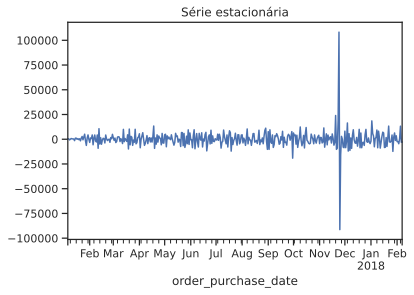

In [94]:
ds_day_train_diff.plot()
plt.title('Série estacionária')
plt.show()

####Modelo Naive

Primeiramente iniciaremos com um modelo simples apenas para ter como base sobre o nível mínimo de qualidade aceitável.
Neste modelo consideramos que o próximo período é exatamente o período imediatamente anterior a ele.

In [95]:
df_orders_filtred_day_pred.head()

,price
order_purchase_date,
2017-01-05,396.90
2017-01-06,916.38
2017-01-07,1351.90
2017-01-08,709.58
2017-01-09,673.79


Fazendo a diferenciação para o modelo Naive. 

In [96]:
df_prev_naive =  pd.DataFrame(ds_day_test)
df_prev_naive['naive'] = df_prev_naive.shift(1)
df_prev_naive.head()

,price,naive
order_purchase_date,,
2018-02-08,27074.86,NaN
2018-02-09,30571.07,27074.86
2018-02-10,20579.17,30571.07
2018-02-11,22350.18,20579.17
2018-02-12,23255.73,22350.18


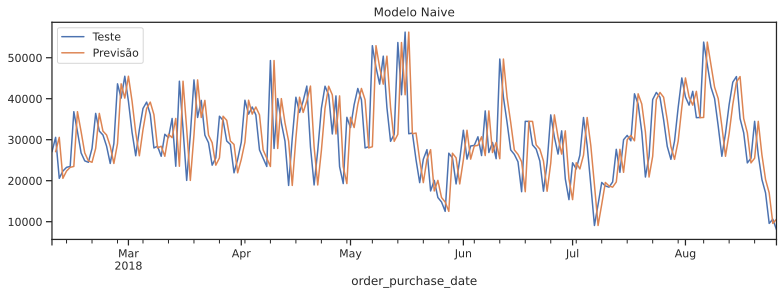

In [97]:
#perído que será utilizado para previsões dos outros modelos
df_prev_naive.plot(figsize=(13,4),title='Modelo Naive')
plt.legend(['Teste','Previsão'])
plt.show()

Plotando no gráfico juntamente com os dados reais.

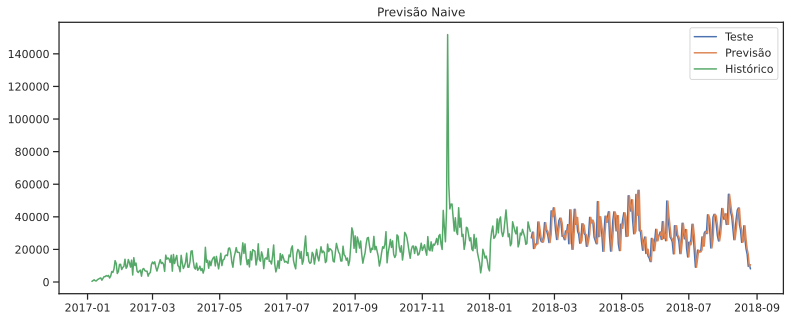

In [98]:
plt.figure(figsize=(13,5))
plt.plot(df_prev_naive['price'])
plt.plot(df_prev_naive['naive'])
plt.plot(ds_day_train)
plt.legend(['Teste','Previsão','Histórico'])
plt.title('Previsão Naive')
plt.show()


Validação do modelo

In [99]:
df_prev_naive.dropna(inplace=True)
y_true = df_prev_naive.price
y_pred = df_prev_naive.naive
resid_naive = y_true-y_pred
prediction_teste_error('Naive',y_true=y_true,y_pred=y_pred)

Modelo Naive Resultados: MAE : 6466.879648241223, MAPE : 21.95394997737745, MSE : 67976123.12699176, RMSE : 8244.763376046141 


In [100]:
resid_naive.describe()

count      199.000000
mean       -95.498241
std       8265.002777
min     -24788.200000
25%      -5642.355000
50%      -1130.390000
75%       5153.295000
max      25844.880000
dtype: float64

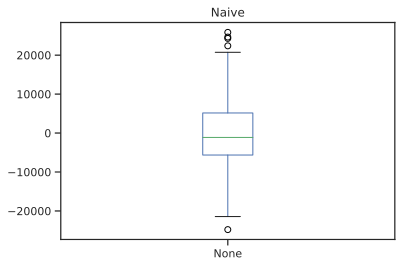

In [101]:
resid_naive.plot(kind="box",title="Naive")
plt.show()

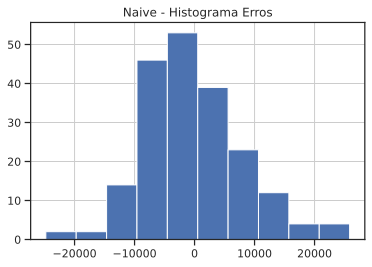

In [102]:
resid_naive.hist()
plt.title('Naive - Histograma Erros')
plt.show()

####Modelo Auto Regressivo

Auto regressão de ordem 2, como foi sugerido pela análise de auto correlação, pois o lag 2 tem uma forte correlação e está dentro do intervalo de confiança.
Vamos utilizar o método AutoReg do módulo ar_model para aplicar este modelo.

In [103]:
df_prev_ar_sts =  pd.DataFrame(ds_day_train.copy())
#Treino
ar2 = AutoReg(df_prev_ar_sts.price, lags=2, old_names=False).fit()
print(ar2.summary())

                            AutoReg Model Results                             
Dep. Variable:                  price   No. Observations:                  399
Model:                     AutoReg(2)   Log Likelihood               -4139.180
Method:               Conditional MLE   S.D. of innovations           8161.691
Date:                Sat, 06 Feb 2021   AIC                             18.035
Time:                        16:59:19   BIC                             18.075
Sample:                    01-07-2017   HQIC                            18.050
                         - 02-07-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4754.8844    812.135      5.855      0.000    3163.129    6346.640
price.L1       0.5697      0.049     11.528      0.000       0.473       0.667
price.L2       0.1722      0.049      3.486      0.0

In [104]:
#Previsão
y_pred_ar2 = ar2.params[0]
for i, coef in enumerate(ar2.params[1:]):
  y_pred_ar2 += coef * ds_day_test.shift(i + 1)
#avaliação do modelo
y_true = ds_day_test[2:].values
y_pred_ar2.dropna(inplace=True)
prediction_teste_error(' AR(2)',y_true=y_true,y_pred=y_pred_ar2)

Modelo  AR(2) Resultados: MAE : 6100.111162953462, MAPE : 19.835342242404543, MSE : 66421841.23579456, RMSE : 8149.959584917864 


Comparativo dados previstos e dados testes.

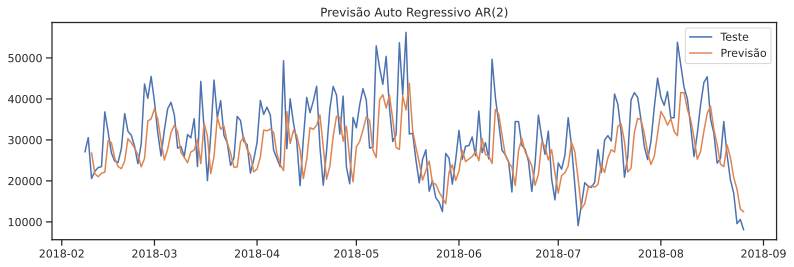

In [105]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(y_pred_ar2)
plt.legend(['Teste','Previsão'])
plt.title('Previsão Auto Regressivo AR(2)')
plt.show()

Visualização juntamente com os dados treino e teste.

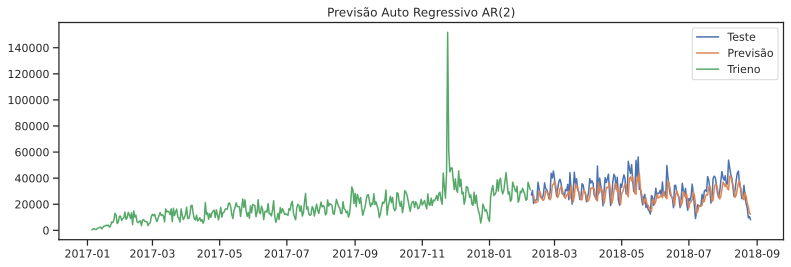

In [106]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(y_pred_ar2)
plt.plot(ds_day_train)
plt.legend(['Teste','Previsão','Trieno'])
plt.title('Previsão Auto Regressivo AR(2)')
plt.show()

Abaixo vamos executar o modelo auto regressivo com lag=3 para ver se conseguimos uma melhor acurácia.

In [107]:
#Treino
ar3 = AutoReg(ds_day_train, lags=3).fit()
#Previsão
y_pred_ar3 = ar3.params[0]
for i, coef in enumerate(ar3.params[1:]):
  y_pred_ar3 += coef * ds_day_test.shift(i + 1)

y_true = ds_day_test[3:].values
#avaliação do modelo
prediction_teste_error('AR(3)',y_true=y_true,y_pred=y_pred_ar3.dropna())

Modelo AR(3) Resultados: MAE : 6219.796460887838, MAPE : 20.760544610592667, MSE : 64732593.874218404, RMSE : 8045.6568329887405 


Com o lag=3 ficou pior o nível de acurácia. Vamos considerar o modelo AR(2)

Avaliação final do modelo<br>
Então, escolhemos o modelo AR(2) como o melhor modelo, vamos análisar os erros obitdos a partir deste modelo.

In [108]:
ar2.resid.describe()

count    3.970000e+02
mean     2.859066e-12
std      8.171990e+03
min     -3.824102e+04
25%     -3.826046e+03
50%     -9.111440e+02
75%      2.900042e+03
max      1.179551e+05
dtype: float64

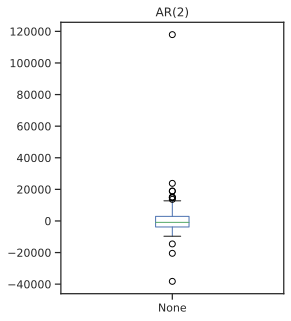

In [109]:
plt.figure(figsize=(4,5))
ar2.resid.plot(kind='box')
plt.title('AR(2)')
plt.show()

Podemos observar que a média ficou bem próxima de zero, porém ainda tivemos muitos outliers.

####Modelo ARMA

Este modelo é composto pelo modelo Auto Regressivo (AR) com ajuste dos erros residuais o componente de Média Móvel (MA). Seus parâmetros são (*p* , *q*) onde *p* é a quantidade lags para o componente de auto regressão e *q* define a quantidade lags para o componente de média móvel. A configuração mais utilizada deste modelo é ARMA(1,1), iremos começar testando estes hiperparâmetros.

In [110]:
df_prev_arma_train_1 = ARMA(ds_day_train,freq='D',order=(1,1)).fit()
df_prev_arma_test_1 = ARMA(ds_day_test,freq='D',order=(1,1)).fit(df_prev_arma_train_1.params)
print(df_prev_arma_test_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  200
Model:                     ARMA(1, 1)   Log Likelihood               -2065.034
Method:                       css-mle   S.D. of innovations           7369.998
Date:                Sat, 06 Feb 2021   AIC                           4138.068
Time:                        16:59:20   BIC                           4151.261
Sample:                    02-08-2018   HQIC                          4143.407
                         - 08-26-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.067e+04   1265.350     24.240      0.000    2.82e+04    3.32e+04
ar.L1.price     0.5958      0.099      6.029      0.000       0.402       0.790
ma.L1.price    -0.0128      0.121     -0.106    

In [111]:
#Teste do modelo
#Dados para teste
y_true_arma = ds_day_test.values
#Avaliação
prediction_teste_error('ARMA(1,1)',y_true=y_true_arma,y_pred=df_prev_arma_test_1.predict())

Modelo ARMA(1,1) Resultados: MAE : 5737.586752631613, MAPE : 21.224542379651737, MSE : 54339200.976894684, RMSE : 7371.5128011076995 


Obtivemos um AIC de  4138.068, vamos testar com a configuração ARMA(1,2).

In [112]:
df_prev_arma_train_2 = ARMA(ds_day_train,freq='D',order=(1,2)).fit()
df_prev_arma_test_2 = ARMA(ds_day_test,freq='D',order=(1,2)).fit(df_prev_arma_train_2.params)
print(df_prev_arma_test_2.summary())

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  200
Model:                     ARMA(1, 2)   Log Likelihood               -2064.880
Method:                       css-mle   S.D. of innovations           7363.148
Date:                Sat, 06 Feb 2021   AIC                           4139.759
Time:                        16:59:21   BIC                           4156.251
Sample:                    02-08-2018   HQIC                          4146.433
                         - 08-26-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.036e+04   1728.411     17.566      0.000     2.7e+04    3.37e+04
ar.L1.price     0.8538      0.098      8.756      0.000       0.663       1.045
ma.L1.price    -0.3135      0.131     -2.395    

In [113]:
#Avaliação
prediction_teste_error('ARMA(1,2)',y_true=y_true_arma,y_pred=df_prev_arma_test_2.predict())

Modelo ARMA(1,2) Resultados: MAE : 5773.790711023952, MAPE : 21.33100594862509, MSE : 54245818.395692684, RMSE : 7365.176060060797 


Obtivemos um AIC melhor, 4139.759, como sabemos da forte correlação do lag=2 vamos testar a configuração p=2 e d=2.

In [114]:
#Treino
df_prev_arma_train_3 = ARMA(ds_day_train,freq='D',order=(2,2)).fit()
#Previsão
df_prev_arma_test_3 = ARMA(ds_day_test,freq='D',order=(2,2)).fit(df_prev_arma_train_3.params)
print(df_prev_arma_test_3.summary())

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  200
Model:                     ARMA(2, 2)   Log Likelihood               -2063.935
Method:                       css-mle   S.D. of innovations           7328.579
Date:                Sat, 06 Feb 2021   AIC                           4139.870
Time:                        16:59:21   BIC                           4159.660
Sample:                    02-08-2018   HQIC                          4147.879
                         - 08-26-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.039e+04   1709.211     17.779      0.000     2.7e+04    3.37e+04
ar.L1.price     1.1900      0.225      5.287      0.000       0.749       1.631
ar.L2.price    -0.2760      0.186     -1.486    

In [115]:
#Avaliação
prediction_teste_error('ARMA(2,2)',y_true=y_true_arma,y_pred=df_prev_arma_test_3.predict())

Modelo ARMA(2,2) Resultados: MAE : 5731.920328415472, MAPE : 21.177033500906525, MSE : 53733931.33064007, RMSE : 7330.343193237276 


Conseguimos um ajuste melhor, vamos verificar com os hiperparametros p=2 e d=3.

In [116]:
#Treino
df_prev_arma_train_4 = ARMA(ds_day_train,freq='D',order=(2,3)).fit()
#Previsão
df_prev_arma_test_4 = ARMA(ds_day_test,freq='D',order=(2,3)).fit(df_prev_arma_train_4.params)
print(df_prev_arma_test_4.summary())

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  200
Model:                     ARMA(2, 3)   Log Likelihood               -2063.149
Method:                       css-mle   S.D. of innovations           7298.815
Date:                Sat, 06 Feb 2021   AIC                           4140.299
Time:                        16:59:23   BIC                           4163.387
Sample:                    02-08-2018   HQIC                          4149.642
                         - 08-26-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.033e+04   1764.423     17.192      0.000    2.69e+04    3.38e+04
ar.L1.price     0.3077      0.334      0.920      0.357      -0.348       0.963
ar.L2.price     0.4999      0.282      1.770    

In [117]:
#Avaliação
prediction_teste_error('ARMA(2,3)',y_true=y_true_arma,y_pred=df_prev_arma_test_4.predict())

Modelo ARMA(2,3) Resultados: MAE : 5742.4891467030475, MAPE : 21.224967851684866, MSE : 53305515.209909655, RMSE : 7301.062608272145 


Este ajuste ficou um pouco melhor. Vamos avaliar a acurácia das configurações (2,2) e (2,3).

O modelo ARMA(2,2) teve uma acurácia melhor para as métricas médias, porém o modelo ARMA(2,3) teve os melhores resultados para as métricas de erros quadráticas. Sendo assim, vamos fazer as representações gráficas do modelo ARMA(2,2) pois significa que tivemos um menor erro médio menor.

Comparação Previsão e Teste

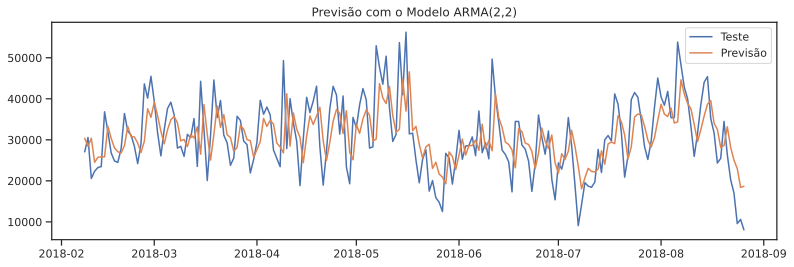

In [118]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(df_prev_arma_test_3.predict())
plt.legend(['Teste','Previsão'])
plt.title('Previsão com o Modelo ARMA(2,2)')
plt.show()

Gráfico completo

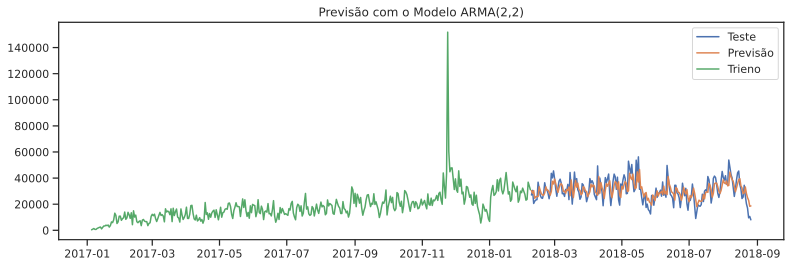

In [119]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(df_prev_arma_test_3.predict())
plt.plot(ds_day_train)
plt.title('Previsão com o Modelo ARMA(2,2)')
plt.legend(['Teste','Previsão','Trieno'])
plt.show()

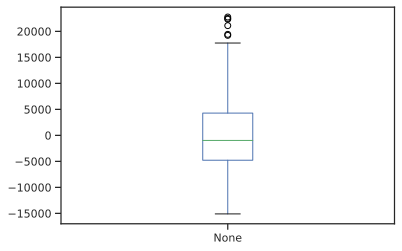

In [120]:
df_prev_arma_test_3.resid.plot(kind='box')
plt.show()

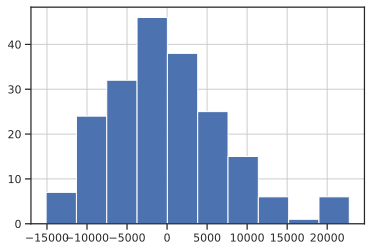

In [121]:
df_prev_arma_test_3.resid.hist()
plt.show()

####Modelo ARIMA

É um modelo auto regressivo de médias móveis integrado, ele é composto pelo componente de auto regressão (AR), componente de integração (I) que é a diferenciação da série, a fim de torná-la estacionária e o componente de médias móveis (MA). Neste modelo, temos por parâmetros (*p*,*d*,*q*) que são eles; *p* é a ordem do lag, onde informamos o número e observações passadas para serem consideradas pelo componente de auto regressão, *d* é o grau de diferenciação, pelo qual informamos o número de diferenciações a serem realizadas no componente de integração e por fim o parâmetro *q*, que é a ordem de média móvel, onde informamos o tamanho da janela de média móvel a ser considerada.

In [122]:
#Treino
df_prev_arima_train_1 = ARIMA(ds_day_train,freq='D',order=(2,1,2)).fit()
#Previsão
df_prev_arima_test_1 = ARIMA(ds_day_test,freq='D',order=(2,1,2)).fit(df_prev_arima_train_1.params)
#Avaliação
y_true = ds_day_test[1:].values
y_pred_arima_1 = df_prev_arima_test_1.predict(typ='levels')
prediction_teste_error('ARIMA(2,1,2)',y_true=y_true,y_pred=y_pred_arima_1)

Modelo ARIMA(2,1,2) Resultados: MAE : 5529.024957174562, MAPE : 19.58374513687546, MSE : 51870707.04280326, RMSE : 7202.132117838665 


In [123]:
#Treino
df_prev_arima_train_2 = ARIMA(ds_day_train,freq='D',order=(3,1,2)).fit()
#Previsão
df_prev_arima_test_2 = ARIMA(ds_day_test,freq='D',order=(3,1,2)).fit(df_prev_arima_train_2.params)
print(df_prev_arima_test_2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  199
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2040.698
Method:                       css-mle   S.D. of innovations           6841.819
Date:                Sat, 06 Feb 2021   AIC                           4095.395
Time:                        16:59:26   BIC                           4118.449
Sample:                    02-09-2018   HQIC                          4104.726
                         - 08-26-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -74.9712    275.351     -0.272      0.785    -614.648     464.706
ar.L1.D.price     0.8227      0.073     11.286      0.000       0.680       0.966
ar.L2.D.price    -0.4603      0.084     

In [124]:
#Avaliação
y_true = ds_day_test[1:].values
y_pred_arima_2 = df_prev_arima_test_2.predict(typ='levels')
prediction_teste_error('ARIMA(3,1,2)',y_true=y_true,y_pred=y_pred_arima_2)

Modelo ARIMA(3,1,2) Resultados: MAE : 5227.105152547895, MAPE : 18.4069066953502, MSE : 47047273.92239205, RMSE : 6859.101539005823 


Comparação previsão e teste

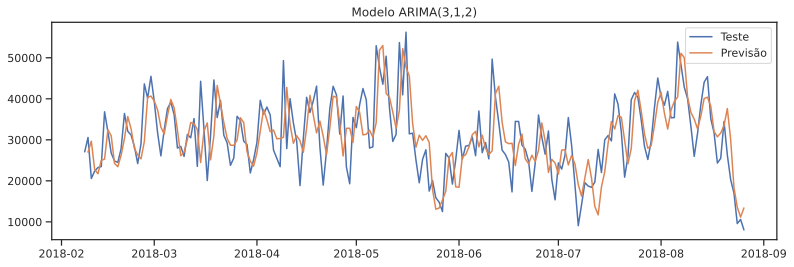

In [125]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(df_prev_arima_test_2.predict(typ='levels'))
plt.legend(['Teste','Previsão'])
plt.title('Modelo ARIMA(3,1,2)')
plt.show()

Visualização completa

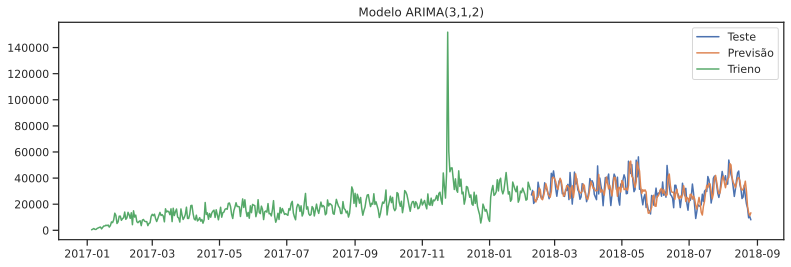

In [126]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(df_prev_arima_test_2.predict(typ='levels'))
plt.plot(ds_day_train)
plt.legend(['Teste','Previsão','Trieno'])
plt.title('Modelo ARIMA(3,1,2)')
plt.show()

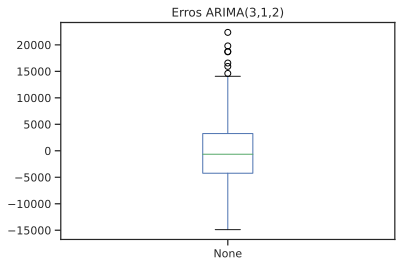

In [127]:
df_prev_arima_test_2.resid.plot(kind='box')
plt.title('Erros ARIMA(3,1,2)')
plt.show()

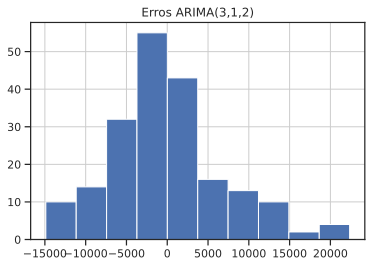

In [128]:
df_prev_arima_test_2.resid.hist()
plt.title('Erros ARIMA(3,1,2)')
plt.show()

####Modelo SARIMA

O SARIMA (Sazonal Autoregressive Integrated Moving Average) é um modelo que considera o componente sazonal juntamente com os componentes auto regressivos, de integração e de médias móveis. <br>
Elementos de tendências; 

*   *p* ordem de AR,
*   *d* ordem de diferenças,
*   *q* ordem de MA.

Elementos Sazonais;
 

*   *P* ordem de AR sazonal,
*   *D* ordem das diferenças sazonal,
*   *Q* ordem de MA sazonal,
*   *s* número de períodos referentes ao ciclo sazonal.

Sendo expresso da seguinte forma **SARIMA(p,d,q)(P,D,Q)s**.

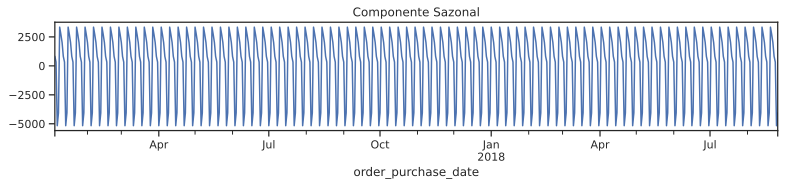

In [129]:
#Componente sazonal
plt.figure(figsize=(13,2))
result_day_decompose.seasonal.plot()
plt.title("Componente Sazonal")
plt.show()

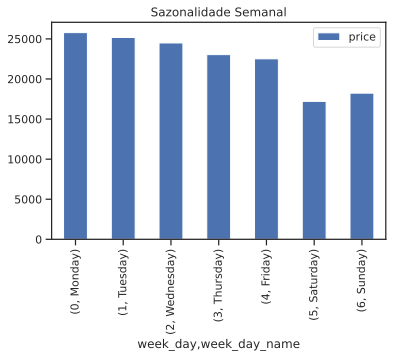

In [130]:
#Confirmar a presença da sazonalidade semanal
df_prev_sarima = df_orders_filtred_day.copy()
df_prev_sarima.reset_index(inplace=True)
df_prev_sarima.set_index('order_purchase_date',inplace=True)
df_prev_sarima['week_day'] = df_prev_sarima.index.weekday
df_prev_sarima['week_day_name'] = df_prev_sarima.index.day_name()
df_prev_sarima_day_name = df_prev_sarima.copy()
df_prev_sarima_day_name.sort_values('week_day', inplace=True)
df_prev_sarima_day_name = df_prev_sarima.groupby(['week_day','week_day_name']).mean()
df_prev_sarima_day_name.plot(kind='bar')
plt.title("Sazonalidade Semanal")
plt.show()

In [131]:
#Treino
df_prev_sarima_train = SARIMAX(ds_day_train,freq='D',order=(3,1,2), seasonal_order=(3,1,2,7)).fit()
#Previsao
df_prev_sarima_test = SARIMAX(ds_day_test,freq='D',order=(3,1,2), seasonal_order=(3,1,2,7)).fit(df_prev_sarima_train.params)
print(df_prev_sarima_test.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             price   No. Observations:                  200
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 7)   Log Likelihood               -1991.076
Date:                           Sat, 06 Feb 2021   AIC                           4004.153
Time:                                   16:59:42   BIC                           4039.985
Sample:                               02-08-2018   HQIC                          4018.665
                                    - 08-26-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7253      0.849     -0.854      0.393      -2.390       0.939
ar.L2          0.1362      1.077      0.126

In [132]:
#Avaliação
y_true = ds_day_test[1:].values
df_prev_sarima_pred = df_prev_sarima_test.predict(typ='levels')[1:]
prediction_teste_error('SARIMAX(3,1,2)(3,1,2,7)',y_true=y_true,y_pred=df_prev_sarima_pred)

Modelo SARIMAX(3,1,2)(3,1,2,7) Resultados: MAE : 5116.197412310387, MAPE : 18.218369739886903, MSE : 42767356.43852531, RMSE : 6539.675560647127 


Comparação Treino/Teste

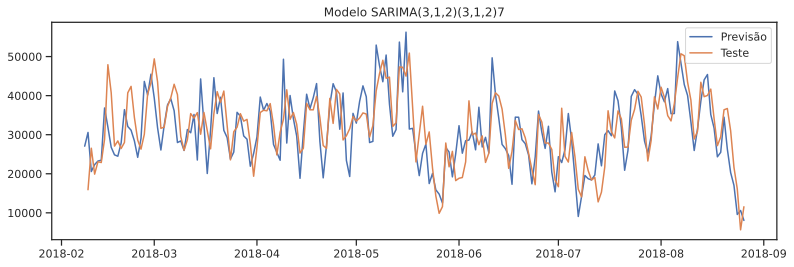

In [133]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(df_prev_sarima_pred)
plt.legend(['Previsão','Teste'])
plt.title('Modelo SARIMA(3,1,2)(3,1,2)7')
plt.show()

Visualização completa

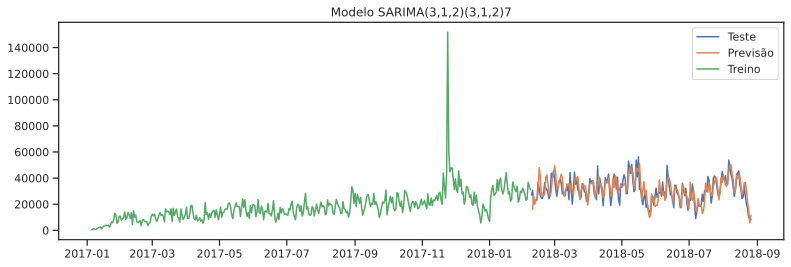

In [134]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(df_prev_sarima_pred)
plt.plot(ds_day_train)
plt.legend(['Teste','Previsão','Treino'])
plt.title('Modelo SARIMA(3,1,2)(3,1,2)7')
plt.show()

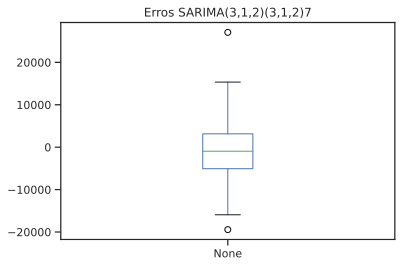

In [135]:
df_prev_sarima_test.resid.plot(kind='box')
plt.title('Erros SARIMA(3,1,2)(3,1,2)7')
plt.show()

####Função Auto-Arima

A função Auto Arima vai nos ajudar a encontrar o melhor modelo com a composição de parâmetros que vai nos fornecer um melhor ajuste para nossa previsão, dessa forma vamos aplicá-lo para saber qual seria o melhor modelo para nossa previsão.

#####Vamos testar com o parâmetro stepwise=True.

In [136]:
auto_arima_stpw_t = auto_arima(df_orders_filtred_day
                              , start_p=1, max_p=6, start_q=1, max_q=6, m=7
                              , Seasonal=True, start_P=0,d=1,D=1
                              , trace=True
                              , error_action='ignore', suppress_warnings=True
                              , stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=12691.845, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=12467.362, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=12606.690, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=12421.912, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.33 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=12457.746, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=12388.862, Time=0.67 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=12432.539, Time=0.40 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=12319.598, Time=1.65 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=12317.707, Time=0.73 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=12315.721, Time=0.54 sec
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=1

Resumo do resultado do Auto Arima

In [137]:
print(auto_arima_stpw_t.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  599
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -6153.861
Date:                             Sat, 06 Feb 2021   AIC                          12315.721
Time:                                     17:00:06   BIC                          12333.249
Sample:                                          0   HQIC                         12322.549
                                             - 599                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4392      0.021    -20.736      0.000      -0.481      -0.398
ar.L2         -0.2661      

O modelo escolhido foi o SARIMAX(2,1,0)(0,1,1)7

Aplicando o modelo

In [138]:
#Treino
auto_arima_t_train = SARIMAX(ds_day_train,freq='D',order=(2,1,0),seasonal_order=(0,1,1,7)).fit()
#Previsão
auto_arima_t_test = SARIMAX(ds_day_test,freq='D',order=(2,1,0),seasonal_order=(0,1,1,7)).fit(auto_arima_t_train.params)
#Avaliação
y_true = ds_day_test.values
prediction_teste_error('(SARIMAX(2,1,0)(1,1,1)7)',y_true=y_true[1:],y_pred=auto_arima_t_test.predict(typ='levels')[1:])

Modelo (SARIMAX(2,1,0)(1,1,1)7) Resultados: MAE : 5256.875021810676, MAPE : 18.470198857730196, MSE : 43615341.440974094, RMSE : 6604.191202635951 


#####Vamos testar com o parâmetro stepwise=False.

In [139]:
auto_arima_stpw_f = auto_arima(df_orders_filtred_day
                              , start_p=1, max_p=6, start_q=1, max_q=6, m=7
                              , Seasonal=True, start_P=0,d=1,D=1
                              , trace=True
                              , error_action='ignore', suppress_warnings=True
                              , stepwise=False)

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=12691.845, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=2.66 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=12522.680, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=12457.746, Time=0.37 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=1.16 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=12549.847, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.00 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=12386.778, Time=0.97 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=7.75 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=12363.385, Ti

Resumo do modelo escolhido.

In [140]:
print(auto_arima_stpw_f.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  599
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -6136.902
Date:                             Sat, 06 Feb 2021   AIC                          12285.803
Time:                                     17:02:42   BIC                          12312.094
Sample:                                          0   HQIC                         12296.045
                                             - 599                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5063      0.026    -19.283      0.000      -0.558      -0.455
ar.L2         -0.3761      

Como temos um componene sazonal em nossa série o parâmetro stewise=False teve um resultado melhor, vamos aplicar este modelo a frente.

Previsão

In [141]:
#Treino
auto_arima_f_train = SARIMAX(ds_day_train,freq='D',order=(4,1,0), seasonal_order=(0,1,1,7)).fit()
#Previsão
auto_arima_f_test = SARIMAX(ds_day_test,freq='D',order=(4,1,0), seasonal_order=(0,1,1,7)).fit(auto_arima_f_train.params)
#Avaliação
y_true_auto_arima = ds_day_test.values
y_pred_auto_arima = auto_arima_f_test.predict(typ='levels')[1:]
prediction_teste_error('(SARIMAX(4,1,0)(0,1,1)7)',y_true=y_true[1:],y_pred=y_pred_auto_arima)

Modelo (SARIMAX(4,1,0)(0,1,1)7) Resultados: MAE : 5196.025778792153, MAPE : 18.442043386912776, MSE : 42504593.08898531, RMSE : 6519.554669529607 


Comparação Previsão/Teste

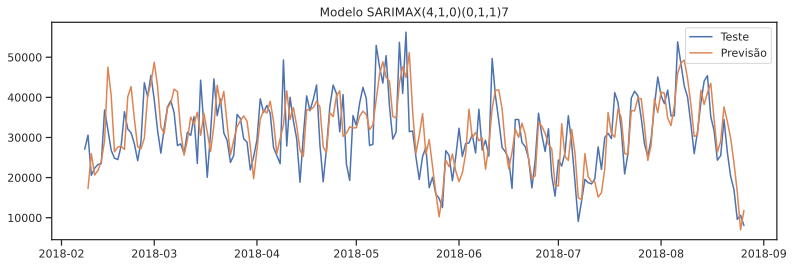

In [142]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(y_pred_auto_arima)
plt.legend(['Teste','Previsão'])
plt.title("Modelo SARIMAX(4,1,0)(0,1,1)7")
plt.show()

Visão completa

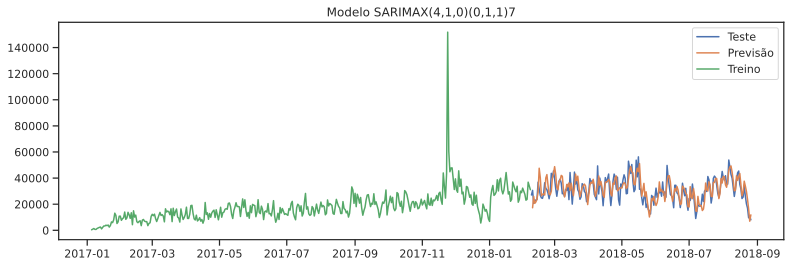

In [143]:
plt.figure(figsize=(13,4))
plt.plot(ds_day_test)
plt.plot(y_pred_auto_arima)
plt.plot(ds_day_train)
plt.legend(['Teste','Previsão','Treino'])
plt.title("Modelo SARIMAX(4,1,0)(0,1,1)7")
plt.show()

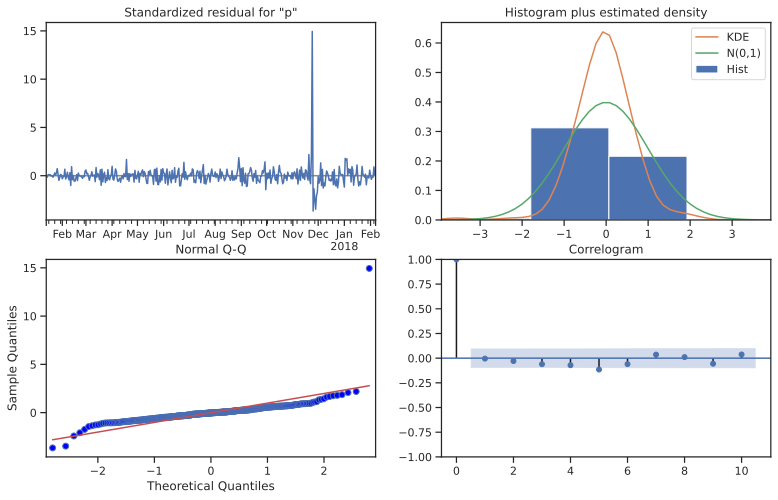

In [144]:
auto_arima_f_train.plot_diagnostics(figsize=(13,8))
plt.show()

O diagnóstico do modelo nos mostra que os erros seguem a distribuição normal.

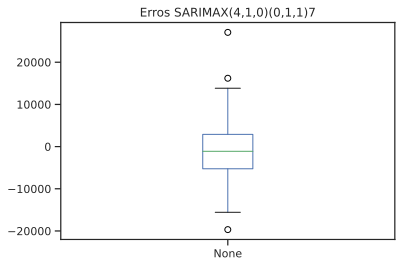

In [145]:
auto_arima_f_test.resid.plot(kind='box')
plt.title("Erros SARIMAX(4,1,0)(0,1,1)7")
plt.show()

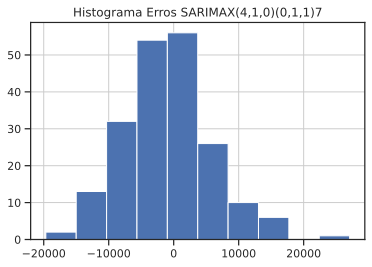

In [146]:
auto_arima_f_test.resid.hist()
plt.title("Histograma Erros SARIMAX(4,1,0)(0,1,1)7")
plt.show()

####Modelo Prophet<br>


O Facebook Prophet foi criado pelo Facebook para facilitar a implementação de modelos de séries temporais mais automatizado, possibilitando sua aplicação sem a necessidade de muito conhecimento estatístico.


In [147]:
#Função a fazer ajunção dos DFs
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [148]:
#Ajsute DF para utilização do Prophet
df_prev_prophet_train = pd.DataFrame(data=ds_day_train,index=ds_day_train.index)
df_prev_prophet_train.dropna(inplace=True)
df_prev_prophet_train.reset_index(inplace=True)
df_prev_prophet_train.columns=['ds','y']

#Treino
prophet_model = Prophet()
prophet_model.fit(df_prev_prophet_train)

prophet_forecast = prophet_model.make_future_dataframe(periods=len(ds_day_test), freq='D',include_history=False)
prophet_forecast = prophet_model.predict(prophet_forecast)

#Avaliação
test = pd.DataFrame(ds_day_test)
test.reset_index(inplace=True)
test.columns = ['ds', 'y']
cmp_df = make_comparison_dataframe(test, prophet_forecast)
cmp_df['resid'] = cmp_df['y']-cmp_df['yhat']

prediction_teste_error('Prophet s/m Ajuste',y_true=cmp_df['y'],y_pred=cmp_df['yhat'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Modelo Prophet s/m Ajuste Resultados: MAE : 8989.31134014505, MAPE : 40.30506337567241, MSE : 130850880.3298977, RMSE : 11439.006964325956 


Obtivemos um resultado pior que o do modelo Naive vamos alterar os hiperparâmtros changepoint_prior_scale e interval_width, para teste.



In [149]:
#Treino
prophet_model = Prophet(changepoint_prior_scale=0.2,interval_width=0.5)
prophet_model.fit(df_prev_prophet_train)

prophet_forecast = prophet_model.make_future_dataframe(periods=len(ds_day_test), freq='D',include_history=False)
prophet_forecast = prophet_model.predict(prophet_forecast)

#Avaliação
test = pd.DataFrame(ds_day_test)
test.reset_index(inplace=True)
test.columns = ['ds', 'y']
cmp_df = make_comparison_dataframe(test, prophet_forecast)
cmp_df['resid'] = cmp_df['y']-cmp_df['yhat']

prediction_teste_error('Prophet',y_true=cmp_df['y'],y_pred=cmp_df['yhat'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Modelo Prophet Resultados: MAE : 7644.659048719121, MAPE : 24.68231758562615, MSE : 94980257.73418626, RMSE : 9745.781535320102 


Ficou um pouco melhor os indeces de acertos, vamos plotar no gráfico esta previsão

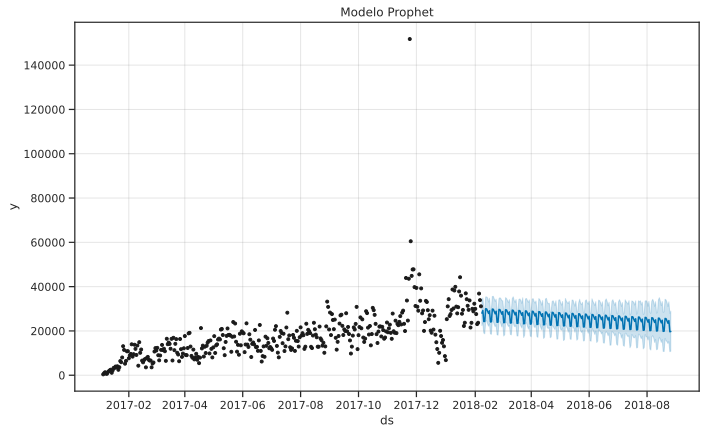

In [150]:
#Gráfico padrão
prophet_model.plot(prophet_forecast)
plt.title("Modelo Prophet")
plt.show()

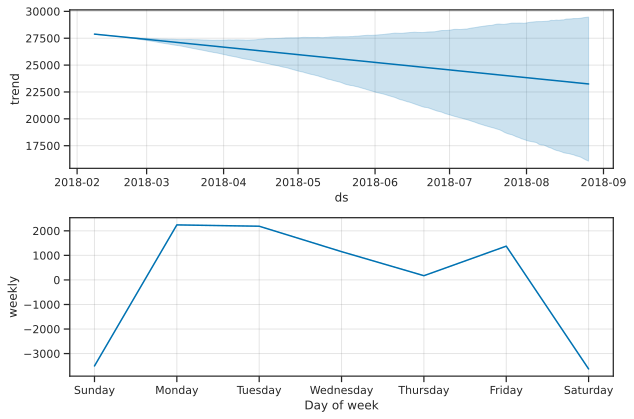

In [151]:
prophet_model.plot_components(prophet_forecast);

Comparação Previsão/Teste

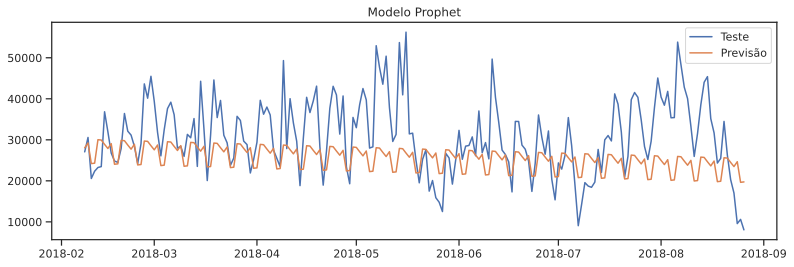

In [152]:
plt.figure(figsize=(13,4))
plt.plot(cmp_df['y'])
plt.plot(cmp_df['yhat'])
plt.legend(['Teste','Previsão'])
plt.title("Modelo Prophet")
plt.show()

Visualização Completa

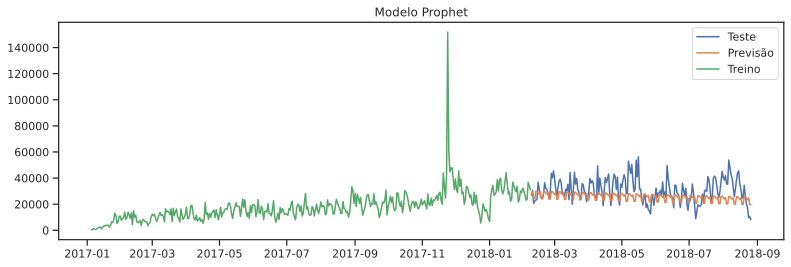

In [153]:
plt.figure(figsize=(13,4))
plt.plot(cmp_df['y'])
plt.plot(cmp_df['yhat'])
plt.plot(df_prev_prophet_train.set_index('ds'))
plt.legend(['Teste','Previsão','Treino'])
plt.title("Modelo Prophet")
plt.show()

####Holt Winters

Vamos utlizar o modelo aditivo pois a série tem um comportamento sazonal constante.

In [154]:
#Preparação
df_prev_holtwinters_train = ds_day_train.copy()
df_prev_holtwinters_test = ds_day_test.copy()
df_prev_holtwinters_train.index.freq = 'D'

In [155]:
#Treino
fitted = HWES(df_prev_holtwinters_train,seasonal_periods=7,trend='add',seasonal='mul').fit()
#Resultado
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    price   No. Observations:                  399
Model:             ExponentialSmoothing   SSE                    25075726407.728
Optimized:                         True   AIC                           7186.526
Trend:                         Additive   BIC                           7230.404
Seasonal:                Multiplicative   AICC                          7187.471
Seasonal Periods:                     7   Date:                 Sat, 06 Feb 2021
Box-Cox:                          False   Time:                         17:02:54
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3585714                alpha                 True
smoothing_trend          

In [156]:
forecast = fitted.forecast(steps=200)
prediction_teste_error('Previsão Holt-Winters',y_true=df_prev_holtwinters_test,y_pred=forecast)

Modelo Previsão Holt-Winters Resultados: MAE : 6264.604431066753, MAPE : 25.162211489164104, MSE : 65626474.90973051, RMSE : 8101.016905903265 


Comparação Previsão/Teste

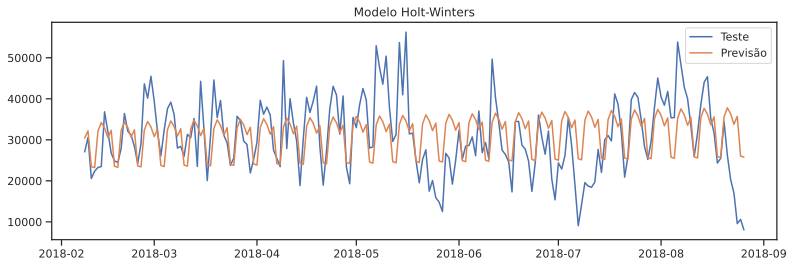

In [157]:
plt.figure(figsize=(13,4))
plt.plot(df_prev_holtwinters_test)
plt.plot(forecast)
plt.legend(['Teste','Previsão'])
plt.title("Modelo Holt-Winters")
plt.show()

Visualização Completa

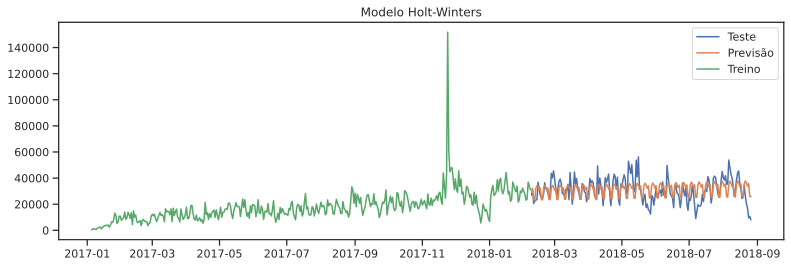

In [158]:
plt.figure(figsize=(13,4))
plt.plot(df_prev_holtwinters_test)
plt.plot(forecast)
plt.plot(df_prev_holtwinters_train)
plt.legend(['Teste','Previsão','Treino'])
plt.title("Modelo Holt-Winters")
plt.show()

####Análise dos Resultados das Métricas

In [165]:
df_results.round(2)

,Model,MAE,MAPE,MSE,RMSE
1,Naive,6466.88,21.95,6.797612e+07,8244.76
6,AR(2),6100.11,19.84,6.642184e+07,8149.96
11,AR(3),6219.80,20.76,6.473259e+07,8045.66
16,"ARMA(1,1)",5737.59,21.22,5.433920e+07,7371.51
21,"ARMA(1,2)",5773.79,21.33,5.424582e+07,7365.18
26,"ARMA(2,2)",5731.92,21.18,5.373393e+07,7330.34
31,"ARMA(2,3)",5742.49,21.22,5.330552e+07,7301.06
36,"ARIMA(2,1,2)",5529.02,19.58,5.187071e+07,7202.13
41,"ARIMA(3,1,2)",5227.11,18.41,4.704727e+07,6859.10
46,"SARIMAX(3,1,2)(3,1,2,7)",5116.20,18.22,4.276736e+07,6539.68


Podemos observar que o modelo que tem a menor média absoluta do erro e o menor percentual é o SARIMA(3,1,2)(3,1,2)7<br>
Porém, o modelo que teve a menor dispersão de erro e erros menores, ou menos outliers, foi o modelo definido pelo auto ARIMA, quando configuramos com o parâmetro Stepwise=False, o modelo que foi sugerido pela função foi o Auto Arima (SARIMAX(4,1,0)(0,1,1)7). Para observarmos de forma mais clara a dispersão podemos visualizar o gráfico de boxplot abaixo.

####Análise dos erros residuais

In [160]:
df_resids.drop('y',axis=1,inplace=True)

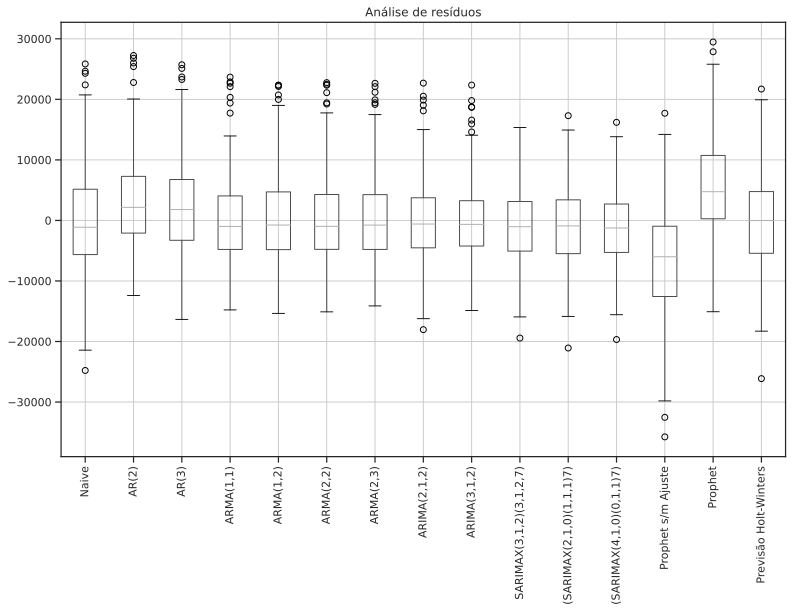

In [161]:
plt.figure(figsize=(13,8))
plt.title('Análise de resíduos')
df_resids.boxplot()
plt.xticks(rotation=90)
plt.show()

Um detalhe importante de ser observado, o modelo de Holt-Winters apesar de não ter os melhores níveis de acertos, pelas métricas apuradas, a mediana de seus erros foi a que esteve mais próxima de zero. Dependendo do cenário este modelo deveria ser considerado.


As estatiíticas dos erros.

In [167]:
df_resids.round(2)

,Naive,AR(2),AR(3),"ARMA(1,1)","ARMA(1,2)","ARMA(2,2)","ARMA(2,3)","ARIMA(2,1,2)","ARIMA(3,1,2)","SARIMAX(3,1,2)(3,1,2,7)","(SARIMAX(2,1,0)(1,1,1)7)","(SARIMAX(4,1,0)(0,1,1)7)",Prophet s/m Ajuste,Prophet,Previsão Holt-Winters
order_purchase_date,,,,,,,,,,,,,,,
2018-02-08,NaN,NaN,NaN,-3597.36,-3285.92,-3312.46,-3258.98,NaN,NaN,NaN,NaN,NaN,-4137.30,-978.83,-3361.55
2018-02-09,3496.21,NaN,NaN,2012.17,2118.30,2151.16,2166.75,3576.61,3571.18,14645.10,13407.04,13284.89,-1906.74,1337.13,-1610.02
2018-02-10,-9991.90,-6253.82,NaN,-10007.03,-9754.60,-9808.90,-9817.96,-9508.84,-9086.50,-5950.69,-5766.12,-5371.19,-6971.20,-3630.42,-2886.49
2018-02-11,1771.01,607.88,222.40,-2436.22,-2211.26,-2177.28,-2164.69,1377.23,-431.22,2443.40,-2113.25,1699.31,-5385.99,-1957.18,-868.55
2018-02-12,905.55,2224.63,-365.81,-2489.01,-2862.30,-2498.26,-2194.76,-598.19,1529.57,181.15,742.32,1520.19,-10276.64,-6774.19,-8879.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-22,-6025.93,-5390.45,-4580.54,-7867.24,-7503.46,-7881.86,-7450.67,-8393.00,-9819.08,-10700.40,-8983.85,-9547.79,-24672.84,-4192.10,-16042.81
2018-08-23,-3266.26,-3819.42,-6651.13,-7560.08,-8370.11,-8009.87,-7642.02,-5513.78,-1336.98,-4630.46,-5732.41,-6624.23,-27045.71,-6455.50,-16753.38
2018-08-24,-7445.16,-8366.31,-10176.05,-13055.12,-13519.42,-13403.06,-14118.26,-9613.45,-4003.63,-6539.71,-5316.68,-6869.38,-35756.51,-15080.91,-26133.14


In [171]:
df_resids.describe().round()

,Naive,AR(2),AR(3),"ARMA(1,1)","ARMA(1,2)","ARMA(2,2)","ARMA(2,3)","ARIMA(2,1,2)","ARIMA(3,1,2)","SARIMAX(3,1,2)(3,1,2,7)","(SARIMAX(2,1,0)(1,1,1)7)","(SARIMAX(4,1,0)(0,1,1)7)",Prophet s/m Ajuste,Prophet,Previsão Holt-Winters
count,199.0,198.0,197.0,200.0,200.0,200.0,200.0,199.0,199.0,199.0,199.0,199.0,200.0,200.0,200.0
mean,-95.0,3119.0,2289.0,13.0,34.0,33.0,36.0,-29.0,-5.0,-752.0,-849.0,-1003.0,-6668.0,5333.0,-475.0
std,8265.0,7548.0,7733.0,7390.0,7384.0,7349.0,7319.0,7220.0,6876.0,6513.0,6566.0,6458.0,9318.0,8178.0,8107.0
min,-24788.0,-12399.0,-16353.0,-14778.0,-15364.0,-15106.0,-14118.0,-18044.0,-14883.0,-19434.0,-21079.0,-19675.0,-35757.0,-15081.0,-26133.0
25%,-5642.0,-2096.0,-3281.0,-4795.0,-4828.0,-4780.0,-4795.0,-4534.0,-4234.0,-5073.0,-5490.0,-5284.0,-12566.0,275.0,-5427.0
50%,-1130.0,2159.0,1793.0,-991.0,-761.0,-980.0,-774.0,-598.0,-653.0,-1036.0,-901.0,-1247.0,-6006.0,4740.0,-30.0
75%,5153.0,7272.0,6757.0,4046.0,4714.0,4279.0,4262.0,3744.0,3254.0,3121.0,3400.0,2706.0,-961.0,10729.0,4770.0
max,25845.0,27241.0,25709.0,23669.0,22338.0,22759.0,22648.0,22681.0,22357.0,15344.0,17299.0,16202.0,17701.0,29466.0,21700.0


O modelo que apresentou os erros com a méda mais próxima de zero foi o ARIMA(3,1,2). <br>
O modelo que teve um menor desvio padrão foi o SARIMAX(4,1,0)(0,1,1)7. <br>
O modelo com a menor janela de erro foi o SARIMA(3,1,2)(3,1,2)7. <br>

#**Referências Bibliograficas**

VANDERPLAS, Jake. Python Data Science Handbook: Essential Tools for Working with Data. Cidade: Sebastopol.  O’Reilly Media, Inc, 2017.
REIS, Marcelo Meneses. Análise de Séries Temporais.<br> Disponível em: < https://www.inf.ufsc.br/~marcelo.menezes.reis/Cap4.pdf >.<br> Acesso em: 13/01/2021.
MANCUSO, Aline Castello Branco. Uma Investigação de Desempenho de Métodos de Combinação de Previsões: Simulada e Aplicada.<br> Disponível em: < https://www.lume.ufrgs.br/bitstream/handle/10183/75918/000891325.pdf?sequence=1 >.<br> Acesso em: 13/01/2021.
EHLERS, Ricardo Sanders. Análise de Séries Temporais.<br> Disponível em: < http://www.each.usp.br/rvicente/AnaliseDeSeriesTemporais.pdf >.<br> Acesso em: 13/01/2021.
OLIVEIRA, Pedro Carvalho. Séries Temporais: Analisar o Passado, Predizer o Futuro.<br> Disponível em: < https://student.dei.uc.pt/~pcoliv/reports/ct_timeseries.pdf >.<br> Acesso em: 13/01/2021.
PORTILLA, José. Using Python and Auto ARIMA to Forecast Seasonal Time Series.<br> Disponível em: < https://medium.com/@josemarcialportilla/usingpython-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c >.<br> Acesso em: 13/01/2021.
ZEVIANI, Walmes Marques. Manipulação de dados no Python.<br> Disponível em:  < http://leg.ufpr.br/~walmes/ensino/dsbd/01-python-pandas.html#1 >.<br> Acesso em: 13/01/2021.
MIGON, Hélio. Análise de Séries Temporais.<br> Disponível em:  < http://www.dme.ufrj.br/dani/pdf/slidespartefrequentista.pdf >.<br> Acesso em: 13/01/2021.
BECKER, Marcel Henrique. Modelos para Previsão em Séries Temporais: uma Aplicação para a Taxa de Desemprego na Região Metropolitana de Porto Alegre.<br> Disponível em:  < https://www.lume.ufrgs.br/bitstream/handle/10183/29107/000775660.pdf?sequence=1#:~:text=Os%20m%C3%A9todos%20para%20previs%C3%A3o%20de,passado%20(WHEEL%2C%20WRIGHT%2C%201985 >.<br> Acesso em: 13/01/2021.
MATTOS, Rogério Silva. Tendências e Raízes Unitárias.<br> Disponível em:  < https://www.ufjf.br/wilson_rotatori/files/2011/05/Tendencias-e-Raizes-Unitarias-2018.pdf >.<br> Acesso em: 13/01/2021.
VELASCO, Leandro Henz. Previsão de Demanda de Acessos Móveis no Sistema de Telefonia Brasileiro.<br> Disponível em:  < https://www.lume.ufrgs.br/bitstream/handle/10183/13454/000641161.pdf?...1 >.<br> Acesso em: 13/01/2021.
PANDAS.<br> Disponível em: < https://pandas.pydata.org/ >.<br> Acesso em: 13/01/2021.
NUMPY.<br> Disponível em: < https://numpy.org/ >.<br> Acesso em: 13/01/2021.
SEABORN.<br> Disponível em: < https://seaborn.pydata.org/ >.<br> Acesso em: 13/01/2021.
PROPHET.<br> Disponível em: < https://facebook.github.io/prophet/docs/quick_start.html >.<br> Acesso em: 13/01/2021.
PORTALACTION.<br> Disponível em: < http://www.portalaction.com.br/series-temporais >.<br> Acesso em: 13/01/2021.
